# Sommaire :

<a href="#A6">**Partie 4 : Prédictions**</a>
 - <a href="#C10">4-2 Prédictions variable 'TotalGHGEmissions/sf'</a>
 - <a href="#C11">4-2-1 Baseline : Méthode Naive Mean</a>
 - <a href="#C12">4-2-2 Régularisation KernelRidge</a>
 - <a href="#C13">4-2-3 Régularisation Lasso</a>
 - <a href="#C14">4-2-4 Régularisation ElasticNet</a>
 - <a href="#C15">4-2-5 Régression KNN</a>
 - <a href="#C16">4-2-6 Régression Kernel SVR</a>
 - <a href="#C17">4-2-7 XGboost</a>
 - <a href="#C18">4-2-8 Random Forest</a>
 - <a href="#C19">4-2-9 Synthèse modèle prédictif 'TotalGHGEmissions/sf'</a>
 
<a href="#A7">**Partie 5 : Comparaison avec/sans la variable 'EnergyStar'**</a>

In [1]:
#data
import numpy as np
import pandas as pd
import missingno as msno
import time

#preprocessing
from sklearn import preprocessing
from category_encoders import TargetEncoder

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel

#estimators
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestRegressor

#model selection
from sklearn.model_selection import GridSearchCV

#visualisation
from matplotlib import pyplot as plt
import seaborn as sns
import plotly

In [2]:
df33=pd.read_csv('df33.csv')
df33

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking/sf,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA/sf,SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu)/sf,Electricity(kBtu)/sf,NaturalGas(kBtu)/sf,TotalGHGEmissions/sf,GHGEmissionsIntensity/sf
0,0.000967,0.001735,0.001170,7,0.000910,47.61220,-122.33799,1927,12,88434,0.000000,88434,0.001711,1.000000,189.000000,84.321754,44.621152,14.433962,0.002827,0.000032
1,0.000967,0.001735,0.001170,7,0.000910,47.61390,-122.33283,1926,11,83008,0.000000,83008,0.001711,0.980050,154.699997,73.038352,33.866796,35.509589,0.002122,0.000026
2,0.000967,0.001332,0.001170,7,0.000910,47.61327,-122.33136,1926,8,102761,0.000000,102761,0.001539,1.000000,152.300003,68.779805,35.389447,3.748397,0.002156,0.000021
3,0.000967,0.001735,0.001125,4,0.001072,47.65959,-122.31755,2001,6,88592,0.345246,58006,0.001711,0.654754,148.500000,41.461833,25.580538,15.772338,0.001016,0.000012
4,0.000967,0.001332,0.001170,7,0.000910,47.61500,-122.33081,1930,2,67224,0.000000,67224,0.000672,1.000000,61.200001,19.490608,19.490599,0.000000,0.000136,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,0.000967,0.001735,0.000961,4,0.000791,47.65476,-122.34732,2014,4,126823,0.327535,85284,0.001711,0.695118,169.500000,47.644351,32.451685,15.192662,0.001033,0.000008
1067,0.000967,0.000785,0.000947,2,0.000898,47.54425,-122.31776,1955,1,52085,0.081060,47863,0.000793,1.000000,114.599998,80.303768,14.069367,55.160833,0.003028,0.000058
1068,0.000967,0.001332,0.000988,4,0.001072,47.68109,-122.33282,2013,1,72000,0.000000,72000,0.001990,1.000000,101.800003,44.428583,26.411389,14.224444,0.000940,0.000013
1069,0.000967,0.001677,0.000718,3,0.000898,47.58831,-122.30650,2015,3,45000,0.000000,45000,0.001677,1.016178,96.000000,31.060942,29.466067,0.000000,0.000205,0.000005


# <a name="A6">**Partie 4 : Prédictions**</a>


## <a name="C10">4-2 Prédictions variable 'TotalGHGEmissions/sf'</a>

## Echantillonnage

In [3]:
df42=df33.copy()

In [4]:
[i for i in df42.columns if i.endswith('sf')==True]

['PropertyGFAParking/sf',
 'LargestPropertyUseTypeGFA/sf',
 'SiteEnergyUseWN(kBtu)/sf',
 'Electricity(kBtu)/sf',
 'NaturalGas(kBtu)/sf',
 'TotalGHGEmissions/sf',
 'GHGEmissionsIntensity/sf']

In [5]:
#transformons les data en X et y (SiteEnergyUse(kBtu))
df42.dropna(axis='rows', how='any',inplace=True)
X=df42.drop(columns=['SiteEnergyUseWN(kBtu)/sf',
            'TotalGHGEmissions/sf',
            'GHGEmissionsIntensity/sf'
                    ]
           )
y=df42['TotalGHGEmissions/sf'].values

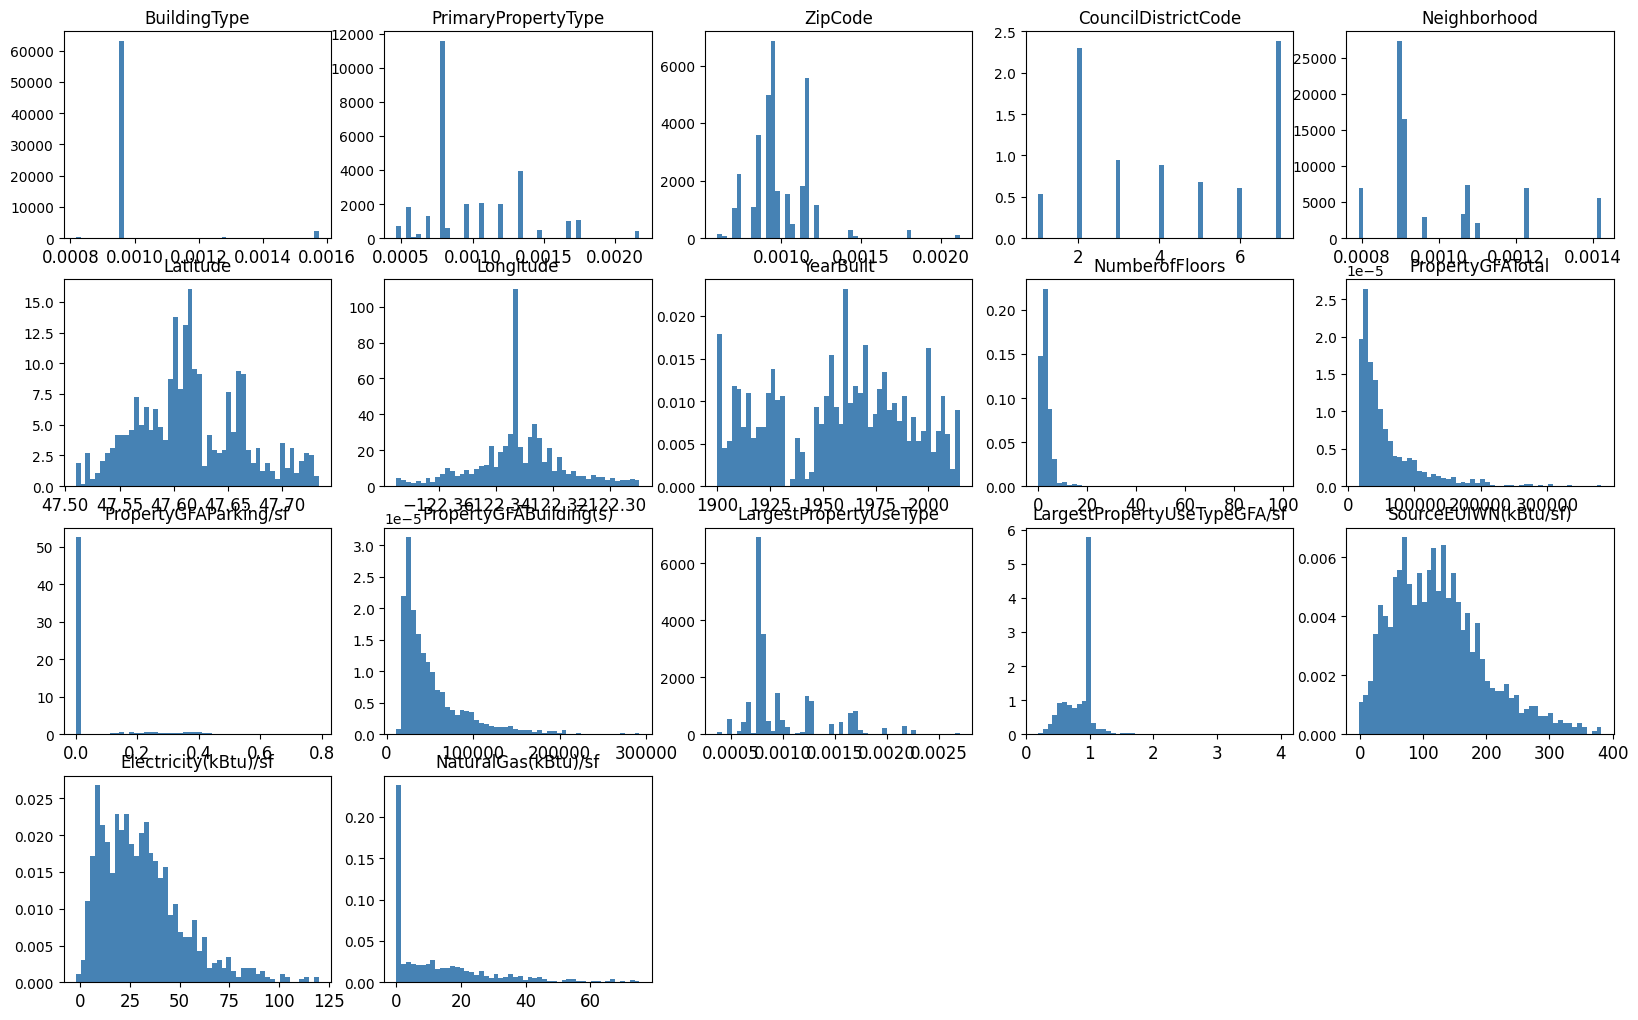

In [6]:
#visualisons les variables
fig = plt.figure(figsize=(20, 80))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(25,5, (feat_idx+1))
    h = ax.hist(X.iloc[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(X.columns[feat_idx], fontsize=12)
    plt.xticks(fontsize=12)#rotation=45,

In [7]:
#découpons en train et test sample
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y,
                                    test_size=0.2,
                                    random_state=42,
                                    )

In [8]:
#standardisons X_train et X_test
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

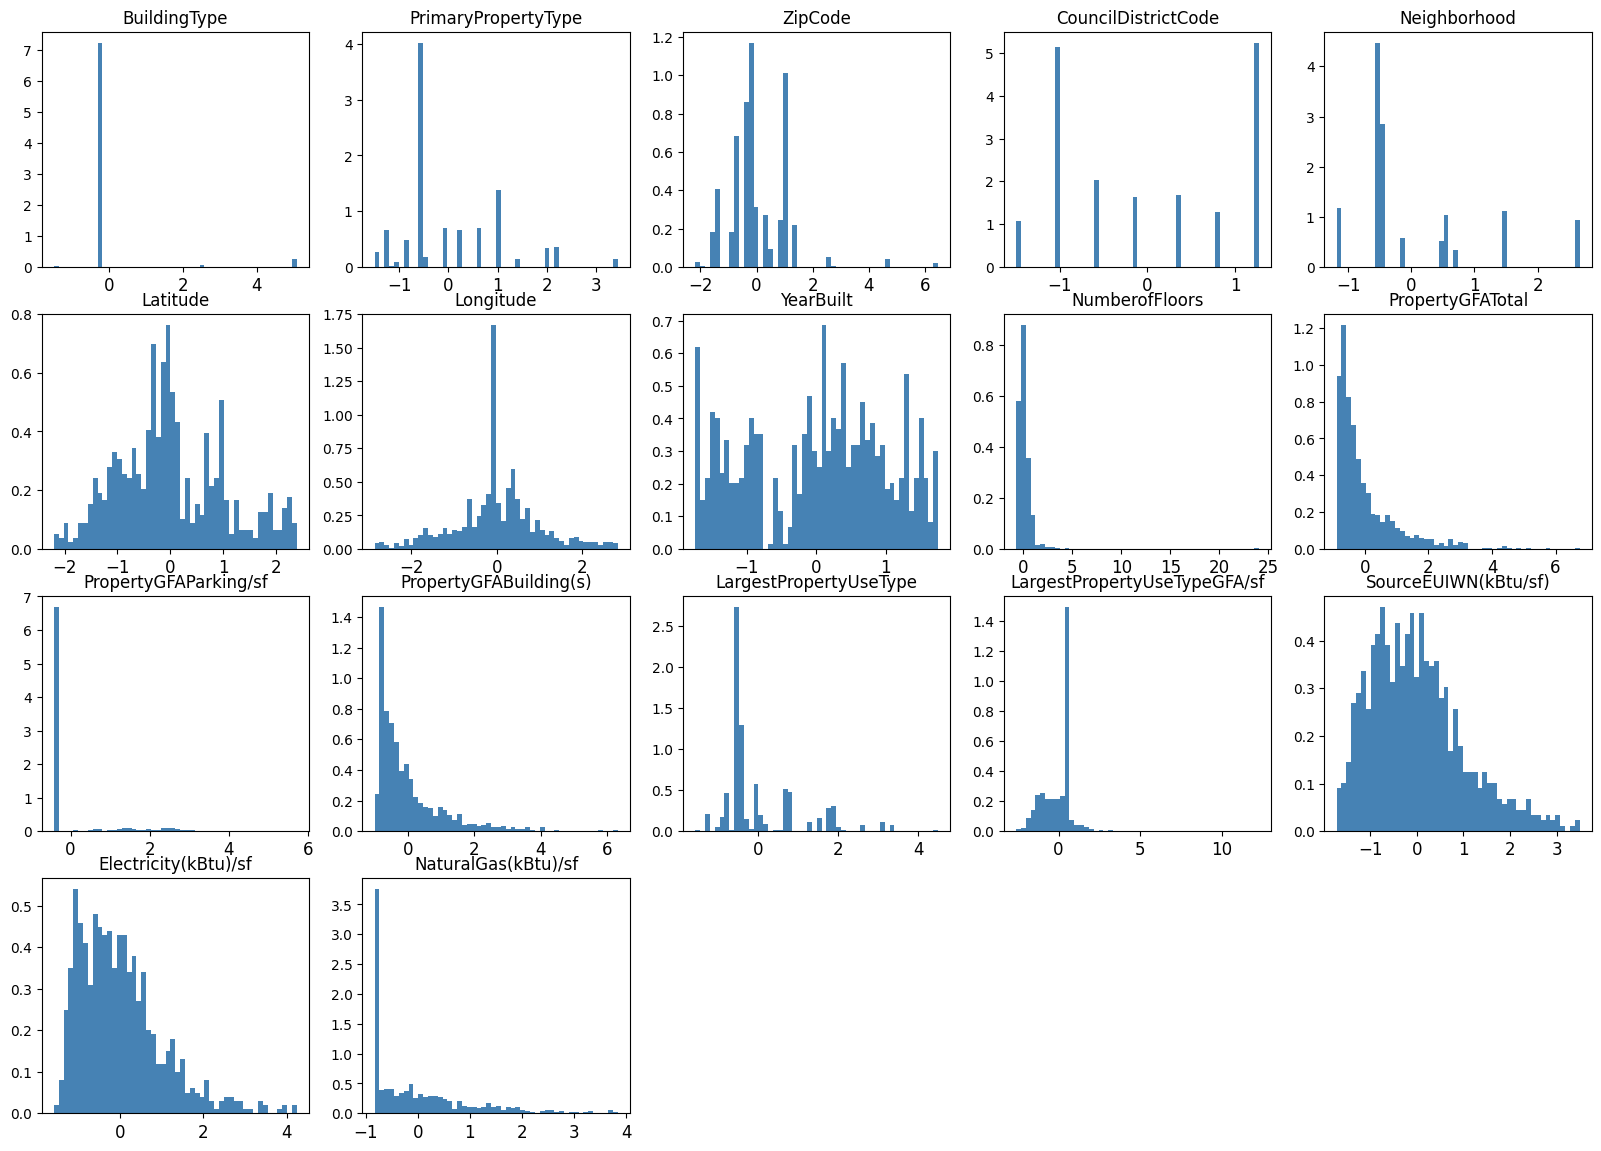

In [9]:
#visualisons les variables transformées
#visualisons les variables
fig = plt.figure(figsize=(20, 80))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(22,5, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(X.columns[feat_idx], fontsize=12)
    plt.xticks(fontsize=12)

## Fonctions

In [10]:
def regression(model, param) :
    #GridSearchCV sur le train set
    NM = GridSearchCV(model(),param,cv=5,verbose=2) 
    NM.fit(X_train_std, y_train)

    #Entraînement du modèle avec les paramètres optimum sur tous le train set
    estNM = model(**NM.best_params_)
    estNM.fit(X_train_std, y_train)

    #Regression sur le test set
    y_pred = estNM.predict(X_test_std)

    #Compraison des scores train et test set
    print('Régression {} train set score R2: {:.2f}, MAE: {:.2f}, mean_squared_error: {:.2f}'
          .format(model,r2_score(y_train, estNM.predict(X_train_std)),mean_absolute_error(y_train, estNM.predict(X_train_std)),
                  mean_squared_error(y_train, estNM.predict(X_train_std))))
    print('Régression {} test set score R2: {:.2f}, MAE: {:.2f}, mean_squared_error: {:.2f}'
          .format(model,r2_score(y_test, y_pred),mean_absolute_error(y_test, y_pred),
                  mean_squared_error(y_test, y_pred)))
    return(estNM, y_pred, NM, mean_absolute_error(y_test, y_pred))

In [11]:
def plot_a(model,estML):
    y_pred_t=estML.predict(X_train_std)

    # Plot residuals
    plt.scatter(y_pred_t, y_pred_t - y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_pred, y_pred - y_test, c = "lightgreen", marker = "s", label = "Test data")
    plt.hlines(y = 0, xmin = 0, xmax = 0.005, color = "red")
    plt.xlim([0,0.005])
    plt.ylim([-0.004,0.002])
    plt.title(f'{model}')
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    
    #plt.axis('tight')
 #   plt.show()
    return(y_pred_t)

In [12]:
def plot_b(model):
    # Plot predictions
    plt.scatter(y_train, y_pred_t, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test, y_pred, c = "lightgreen", marker = "s", label = "Test data")
    plt.plot(y_test,y_test, color = "red")
    plt.xlim([0,0.005])
    plt.ylim([0,0.005])
    plt.ylabel("Predicted values")
    plt.xlabel("Real values")
    plt.legend(loc = "upper left")
    plt.show()

In [13]:
def plot_c(model, estEN):
    # Plot important coefficients
    coefs = pd.Series(estEN.coef_, index = X_train.columns)
    print(f"{model} picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
    imp_coefs = pd.concat([coefs.sort_values().head(10),
                         coefs.sort_values().tail(10)])
    imp_coefs.plot(kind = "barh")
    plt.title(f"Coefficients in the {model}")
    plt.show()

In [14]:
def coef(estEN,model):
    # Plot important coefficients
    coefs = pd.Series(estEN.coef_, index = X_train.columns)
    print(f"{model} picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
    imp_coefs = coefs.sort_values()
    #imp_coefs = pd.concat([coefs.sort_values().head(10),
    #                     coefs.sort_values().tail(10)])
    imp_coefs.plot(kind = "barh")
    plt.title(f"Coefficients in the {model} Model")
    #plt.show()

In [15]:
def evo(model):
    alphas = np.logspace(-3, 6, 200)
    coefs = []
    for a in alphas:
        lasso = model(alpha=a, fit_intercept=False)
        lasso.fit(X_train_std, y_train)
        coefs.append(lasso.coef_)
    #plt.figure(figsize=(40,20))
    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim())#[::-1])  # reverse axis
    #plt.xlabel('alpha',fontsize=40)
    #plt.ylabel('weights',fontsize=40)
    #plt.title(f'{model} coefficients as a function of the regularization',fontsize=40)
    plt.axis('tight')
   # plt.yticks(fontsize=30)
   # plt.xticks(fontsize=30) 
    #plt.show()

## <a name="C11">4-2-1 Baseline : Méthode Naive Mean</a>

In [16]:
time_1=time.time()
(estAN, y_pred, AN,mae_AN)=regression(DummyRegressor,{'strategy':['mean']})
time_AN=time.time()-time_1

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ......................................strategy=mean; total time=   0.0s
[CV] END ......................................strategy=mean; total time=   0.0s
[CV] END ......................................strategy=mean; total time=   0.0s
[CV] END ......................................strategy=mean; total time=   0.0s
[CV] END ......................................strategy=mean; total time=   0.0s
Régression <class 'sklearn.dummy.DummyRegressor'> train set score R2: 0.00, MAE: 0.00, mean_squared_error: 0.00
Régression <class 'sklearn.dummy.DummyRegressor'> test set score R2: -0.00, MAE: 0.00, mean_squared_error: 0.00


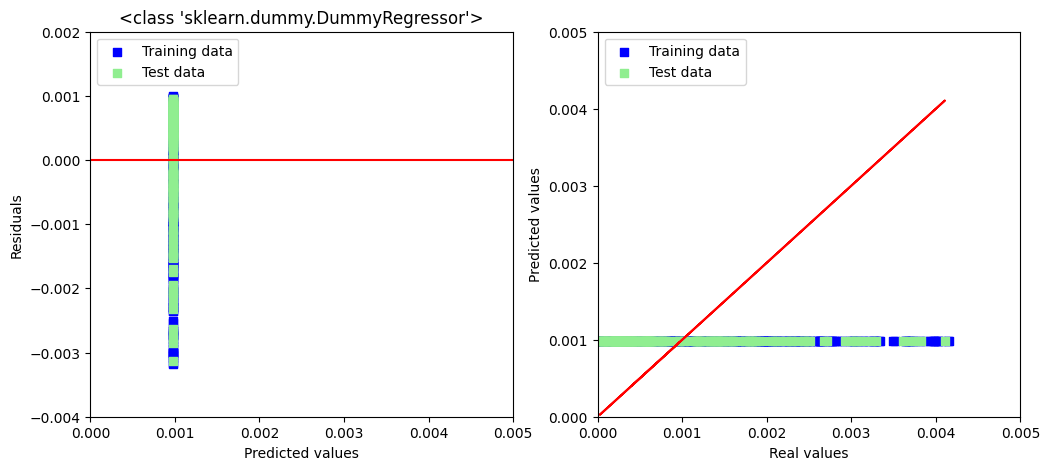

In [17]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
y_pred_t=plot_a(DummyRegressor,estAN)

ax2= plt.subplot(122)
plot_b(y_pred_t)

## <a name="C12">4-2-2 Régularisation KernelRidge</a>

In [18]:
time_1=time.time()
(estKR, y_pred,KR,mae_KR)=regression(KernelRidge,{'kernel':['poly'],'alpha':np.logspace(-3, 6, 200),
             'gamma' : [0, 0.01, 0.1, 0.5, 1, 2]})#['linear', 'poly', 'rbf']
time_KR=time.time()-time_1

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
[CV] END ..................alpha=0.001, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..................alpha=0.001, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..................alpha=0.001, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..................alpha=0.001, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..................alpha=0.001, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...............alpha=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...............alpha=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...............alpha=0.001, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END ...............alpha=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...............alpha=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ................alpha=0.001, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ................alpha=0.001, gamma=

[CV] END .alpha=0.001366716356462006, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.001366716356462006, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.001366716356462006, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.001366716356462006, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.001366716356462006, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.001366716356462006, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.001366716356462006, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.001366716356462006, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.001366716356462006, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.001366716356462006, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.001366716356462006, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.001366716356462006, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.00136671

[CV] END ..alpha=0.0018679135990207828, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.0018679135990207828, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.0018679135990207828, gamma=2, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.0018679135990207828, gamma=2, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.0018679135990207828, gamma=2, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.0018679135990207828, gamma=2, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.0018679135990207828, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.002072921779595372, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.002072921779595372, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.002072921779595372, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.002072921779595372, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.002072921779595372, gamma=0, kernel=poly; total time=   0.0s
[CV] END alpha=0.00207292177

[CV] END alpha=0.002833096101839324, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END alpha=0.002833096101839324, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END alpha=0.002833096101839324, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.002833096101839324, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.002833096101839324, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.002833096101839324, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END .alpha=0.002833096101839324, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.002833096101839324, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.002833096101839324, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.002833096101839324, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.002833096101839324, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.002833096101839324, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.0028330961

[CV] END ...alpha=0.003872038781812557, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.003872038781812557, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.003872038781812557, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.003872038781812557, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.003872038781812557, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.003872038781812557, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.003872038781812557, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.003872038781812557, gamma=2, kernel=poly; total time=   0.1s
[CV] END ...alpha=0.003872038781812557, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.004297004704320844, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.004297004704320844, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.004297004704320844, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.00429700

[CV] END alpha=0.005872786613189483, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END alpha=0.005872786613189483, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END alpha=0.005872786613189483, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END alpha=0.005872786613189483, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.005872786613189483, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.005872786613189483, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.005872786613189483, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.005872786613189483, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.005872786613189483, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.005872786613189483, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.005872786613189483, gamma=0.5, kernel=poly; total time=   0.1s
[CV] END .alpha=0.005872786613189483, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.0058727866

[CV] END .alpha=0.008026433522257174, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .alpha=0.008026433522257174, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.008026433522257174, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.008026433522257174, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.008026433522257174, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.008026433522257174, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.008026433522257174, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.008026433522257174, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.008026433522257174, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.008026433522257174, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.008026433522257174, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.008026433522257174, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.0089073

[CV] END ...alpha=0.012173827277396614, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.012173827277396614, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.012173827277396614, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.012173827277396614, gamma=0, kernel=poly; total time=   0.0s
[CV] END alpha=0.012173827277396614, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END alpha=0.012173827277396614, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END alpha=0.012173827277396614, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END alpha=0.012173827277396614, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END alpha=0.012173827277396614, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.012173827277396614, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.012173827277396614, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.012173827277396614, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .alpha=0.0121738272

[CV] END ..alpha=0.01663816886076129, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.01663816886076129, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.01663816886076129, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.01663816886076129, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.01663816886076129, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.01663816886076129, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.01663816886076129, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.01663816886076129, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.01663816886076129, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.01663816886076129, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.01663816886076129, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.01663816886076129, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.0166381

[CV] END ....alpha=0.02523539170434766, gamma=0, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.02523539170434766, gamma=0, kernel=poly; total time=   0.0s
[CV] END .alpha=0.02523539170434766, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.02523539170434766, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.02523539170434766, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.02523539170434766, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.02523539170434766, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.02523539170434766, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.02523539170434766, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.02523539170434766, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.02523539170434766, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.02523539170434766, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.025235391

[CV] END ..alpha=0.03448962260405758, gamma=0.5, kernel=poly; total time=   0.1s
[CV] END ..alpha=0.03448962260405758, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.03448962260405758, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.03448962260405758, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.03448962260405758, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.03448962260405758, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.03448962260405758, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.03448962260405758, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.03448962260405758, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.03448962260405758, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.03448962260405758, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.03448962260405758, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.0344896

[CV] END ...alpha=0.047137531341167244, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.047137531341167244, gamma=2, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.047137531341167244, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.05231099308056263, gamma=0, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.05231099308056263, gamma=0, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.05231099308056263, gamma=0, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.05231099308056263, gamma=0, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.05231099308056263, gamma=0, kernel=poly; total time=   0.0s
[CV] END .alpha=0.05231099308056263, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.05231099308056263, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.05231099308056263, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.05231099308056263, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.0523109930

[CV] END ..alpha=0.07149428986597581, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.07149428986597581, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.07149428986597581, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.07149428986597581, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.07149428986597581, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.07149428986597581, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.07149428986597581, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.07149428986597581, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.07149428986597581, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.07149428986597581, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.07149428986597581, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.07149428986597581, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.0714942

[CV] END ....alpha=0.09771241535346502, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.09771241535346502, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.09771241535346502, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.09771241535346502, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.09771241535346502, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.09771241535346502, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.1084365968689611, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.1084365968689611, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.1084365968689611, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.1084365968689611, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.1084365968689611, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.1084365968689611, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.108436596

[CV] END .alpha=0.14820207057988585, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.14820207057988585, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.14820207057988585, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .alpha=0.14820207057988585, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.14820207057988585, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.14820207057988585, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.14820207057988585, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.14820207057988585, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.14820207057988585, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.14820207057988585, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.14820207057988585, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.14820207057988585, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.148202070

[CV] END ....alpha=0.20255019392306664, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.20255019392306664, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.20255019392306664, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.20255019392306664, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.20255019392306664, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.20255019392306664, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.20255019392306664, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.20255019392306664, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.20255019392306664, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.20255019392306664, gamma=2, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.22478058335487253, gamma=0, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.22478058335487253, gamma=0, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.2247805

[CV] END .....alpha=0.3072112998861759, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.3072112998861759, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.3072112998861759, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.3072112998861759, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.3072112998861759, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.3072112998861759, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.3072112998861759, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.3072112998861759, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.3072112998861759, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.3072112998861759, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.3072112998861759, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.3072112998861759, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.30721129

[CV] END ....alpha=0.419870708444391, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=0.419870708444391, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ......alpha=0.419870708444391, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=0.419870708444391, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=0.419870708444391, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=0.419870708444391, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=0.419870708444391, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=0.419870708444391, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=0.419870708444391, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=0.419870708444391, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=0.419870708444391, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=0.419870708444391, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.465952

[CV] END ..alpha=0.6368249944718586, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.6368249944718586, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.6368249944718586, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.6368249944718586, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=0.6368249944718586, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.6368249944718586, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.6368249944718586, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.6368249944718586, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.6368249944718586, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.6368249944718586, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.6368249944718586, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.6368249944718586, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=0.63682499

[CV] END ...alpha=0.8703591361485166, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.8703591361485166, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.8703591361485166, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.8703591361485166, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.8703591361485166, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.8703591361485166, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.8703591361485166, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.8703591361485166, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.8703591361485166, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.8703591361485166, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.8703591361485166, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.9658832241158708, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=0.965883

[CV] END ..alpha=1.3200884008314182, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=1.3200884008314182, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=1.3200884008314182, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=1.3200884008314182, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=1.3200884008314182, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=1.3200884008314182, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=1.3200884008314182, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=1.3200884008314182, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=1.3200884008314182, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=1.3200884008314182, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=1.3200884008314182, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=1.3200884008314182, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=1.32008840

[CV] END ...alpha=1.8041864093920719, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=1.8041864093920719, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=1.8041864093920719, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=1.8041864093920719, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=1.8041864093920719, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=1.8041864093920719, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=1.8041864093920719, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=1.8041864093920719, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=1.8041864093920719, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=1.8041864093920719, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=1.8041864093920719, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=1.8041864093920719, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=2.002200

[CV] END ...alpha=2.736439997074672, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=2.736439997074672, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=2.736439997074672, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=2.736439997074672, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=2.736439997074672, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=2.736439997074672, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=2.736439997074672, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=2.736439997074672, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=2.736439997074672, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=2.736439997074672, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=2.736439997074672, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=2.736439997074672, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=2.7364399

[CV] END ......alpha=3.739937302478798, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=3.739937302478798, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=3.739937302478798, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=3.739937302478798, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=3.739937302478798, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=3.739937302478798, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=3.739937302478798, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=3.739937302478798, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=3.739937302478798, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=3.739937302478798, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=4.150404757850477, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=4.150404757850477, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=4.15040

[CV] END ......alpha=5.672426068491977, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=5.672426068491977, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=5.672426068491977, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=5.672426068491977, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=5.672426068491977, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=5.672426068491977, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=5.672426068491977, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=5.672426068491977, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=5.672426068491977, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=5.672426068491977, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=5.672426068491977, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=5.672426068491977, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=5.6724260

[CV] END ....alpha=7.752597488629465, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=7.752597488629465, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=7.752597488629465, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=7.752597488629465, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=7.752597488629465, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=7.752597488629465, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ......alpha=7.752597488629465, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=7.752597488629465, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=7.752597488629465, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=7.752597488629465, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=7.752597488629465, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=7.752597488629465, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=7.75259

[CV] END ......alpha=10.59560179277617, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=11.758495540521581, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=11.758495540521581, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=11.758495540521581, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=11.758495540521581, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=11.758495540521581, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..alpha=11.758495540521581, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=11.758495540521581, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=11.758495540521581, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=11.758495540521581, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=11.758495540521581, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=11.758495540521581, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=11.7584955

[CV] END ...alpha=16.070528182616385, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=16.070528182616385, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=16.070528182616385, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=16.070528182616385, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=16.070528182616385, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=16.070528182616385, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=16.070528182616385, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=16.070528182616385, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=16.070528182616385, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=16.070528182616385, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=16.070528182616385, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=16.070528182616385, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=16.07052

[CV] END ......alpha=21.96385372416547, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=21.96385372416547, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=24.37444150122222, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=24.37444150122222, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=24.37444150122222, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=24.37444150122222, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=24.37444150122222, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=24.37444150122222, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=24.37444150122222, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=24.37444150122222, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=24.37444150122222, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=24.37444150122222, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=24.374441

[CV] END ....alpha=33.31294787934677, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=33.31294787934677, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=33.31294787934677, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=33.31294787934677, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=33.31294787934677, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=33.31294787934677, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=33.31294787934677, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=33.31294787934677, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ......alpha=33.31294787934677, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=33.31294787934677, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=33.31294787934677, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=33.31294787934677, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=33.3129

[CV] END ......alpha=45.52935074866948, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=45.52935074866948, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=45.52935074866948, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=45.52935074866948, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=45.52935074866948, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=45.52935074866948, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=50.526310653356795, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=50.526310653356795, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=50.526310653356795, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=50.526310653356795, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=50.526310653356795, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..alpha=50.526310653356795, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=50.52631065

[CV] END ....alpha=69.0551352016233, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=69.0551352016233, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=69.0551352016233, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....alpha=69.0551352016233, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....alpha=69.0551352016233, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....alpha=69.0551352016233, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....alpha=69.0551352016233, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....alpha=69.0551352016233, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....alpha=69.0551352016233, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=69.0551352016233, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=69.0551352016233, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=69.0551352016233, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=69.05513

[CV] END ......alpha=94.37878277775391, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=94.37878277775391, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=94.37878277775391, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=94.37878277775391, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=94.37878277775391, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=94.37878277775391, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=94.37878277775391, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=94.37878277775391, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=94.37878277775391, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=104.73708979594508, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=104.73708979594508, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=104.73708979594508, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=104.7370

[CV] END .....alpha=143.14589375234786, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=143.14589375234786, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..alpha=143.14589375234786, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=143.14589375234786, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=143.14589375234786, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=143.14589375234786, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=143.14589375234786, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=143.14589375234786, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=143.14589375234786, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=143.14589375234786, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=143.14589375234786, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=143.14589375234786, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=143.145893

[CV] END ...alpha=195.63983435170647, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=195.63983435170647, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=195.63983435170647, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=195.63983435170647, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=195.63983435170647, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=195.63983435170647, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=195.63983435170647, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=195.63983435170647, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=195.63983435170647, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=195.63983435170647, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=195.63983435170647, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=195.63983435170647, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=195.6398

[CV] END .....alpha=267.38416158399497, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=296.73024081888724, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=296.73024081888724, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=296.73024081888724, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=296.73024081888724, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=296.73024081888724, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..alpha=296.73024081888724, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=296.73024081888724, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=296.73024081888724, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=296.73024081888724, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=296.73024081888724, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=296.73024081888724, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=296.730240

[CV] END ...alpha=405.54607358408276, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=405.54607358408276, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=405.54607358408276, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=405.54607358408276, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=405.54607358408276, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=405.54607358408276, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=405.54607358408276, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=405.54607358408276, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=405.54607358408276, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=405.54607358408276, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=405.54607358408276, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=405.54607358408276, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=405.5460

[CV] END ......alpha=554.2664520663108, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=554.2664520663108, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=554.2664520663108, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=554.2664520663108, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=554.2664520663108, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=554.2664520663108, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=615.0985788580505, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=615.0985788580505, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=615.0985788580505, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=615.0985788580505, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=615.0985788580505, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=615.0985788580505, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=615.098578

[CV] END ...alpha=840.6652885618333, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=840.6652885618333, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=840.6652885618333, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=840.6652885618333, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=840.6652885618333, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=840.6652885618333, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=840.6652885618333, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=840.6652885618333, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=840.6652885618333, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=840.6652885618333, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=840.6652885618333, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=840.6652885618333, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=840.66528

[CV] END .....alpha=1148.9510001873086, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=1148.9510001873086, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=1148.9510001873086, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=1148.9510001873086, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=1148.9510001873086, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=1148.9510001873086, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=1148.9510001873086, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=1148.9510001873086, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=1275.051240713013, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=1275.051240713013, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=1275.051240713013, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=1275.051240713013, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=1275.05

[CV] END ..alpha=1742.6333860096508, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=1742.6333860096508, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=1742.6333860096508, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=1742.6333860096508, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=1742.6333860096508, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=1742.6333860096508, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=1742.6333860096508, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=1742.6333860096508, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=1742.6333860096508, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=1742.6333860096508, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=1742.6333860096508, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=1742.6333860096508, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=1742.633

[CV] END .....alpha=2381.6855519761607, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=2381.6855519761607, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=2381.6855519761607, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=2381.6855519761607, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=2381.6855519761607, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=2381.6855519761607, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=2381.6855519761607, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=2381.6855519761607, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=2643.0814869741084, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=2643.0814869741084, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=2643.0814869741084, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=2643.0814869741084, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=2643.081

[CV] END ..alpha=3612.3426997094302, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=3612.3426997094302, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=3612.3426997094302, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=3612.3426997094302, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=3612.3426997094302, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=3612.3426997094302, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=3612.3426997094302, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=3612.3426997094302, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=3612.3426997094302, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=3612.3426997094302, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=3612.3426997094302, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=3612.3426997094302, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=3612.342

[CV] END ......alpha=4937.047852839004, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=4937.047852839004, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=4937.047852839004, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=4937.047852839004, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=4937.047852839004, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=4937.047852839004, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=4937.047852839004, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=4937.047852839004, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=5478.901179593945, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=5478.901179593945, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=5478.901179593945, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=5478.901179593945, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=5478.90

[CV] END ....alpha=7488.10385759003, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=7488.10385759003, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=7488.10385759003, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....alpha=7488.10385759003, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....alpha=7488.10385759003, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....alpha=7488.10385759003, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....alpha=7488.10385759003, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....alpha=7488.10385759003, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....alpha=7488.10385759003, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=7488.10385759003, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=7488.10385759003, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=7488.10385759003, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=7488.103

[CV] END .....alpha=10234.114021054527, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=10234.114021054527, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=10234.114021054527, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=10234.114021054527, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=10234.114021054527, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=10234.114021054527, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=10234.114021054527, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=10234.114021054527, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=11357.333583431051, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=11357.333583431051, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=11357.333583431051, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=11357.333583431051, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=11357.33

[CV] END ......alpha=15522.25357427048, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=15522.25357427048, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=15522.25357427048, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=15522.25357427048, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=15522.25357427048, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=15522.25357427048, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=15522.25357427048, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=15522.25357427048, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=15522.25357427048, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=15522.25357427048, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=15522.25357427048, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=15522.25357427048, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=15522.253

[CV] END ....alpha=21214.51784910632, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=21214.51784910632, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=21214.51784910632, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=21214.51784910632, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ......alpha=21214.51784910632, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=21214.51784910632, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=21214.51784910632, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=21214.51784910632, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=21214.51784910632, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=21214.51784910632, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=21214.51784910632, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=21214.51784910632, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=21214.5

[CV] END ......alpha=28994.22853882881, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=28994.22853882881, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=32176.417502507353, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=32176.417502507353, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=32176.417502507353, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=32176.417502507353, gamma=0, kernel=poly; total time=   0.0s
[CV] END .....alpha=32176.417502507353, gamma=0, kernel=poly; total time=   0.0s
[CV] END ..alpha=32176.417502507353, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=32176.417502507353, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=32176.417502507353, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=32176.417502507353, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..alpha=32176.417502507353, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=32176.4175

[CV] END ...alpha=43976.036093027215, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=43976.036093027215, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=43976.036093027215, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=43976.036093027215, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=43976.036093027215, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=43976.036093027215, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=43976.036093027215, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=43976.036093027215, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=43976.036093027215, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=43976.036093027215, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=43976.036093027215, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=43976.036093027215, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=43976.03

[CV] END ......alpha=60102.76782070388, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=60102.76782070388, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=60102.76782070388, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=60102.76782070388, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=60102.76782070388, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=66699.19663030129, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=66699.19663030129, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=66699.19663030129, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=66699.19663030129, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=66699.19663030129, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=66699.19663030129, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=66699.19663030129, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=66699.1966

[CV] END ....alpha=91158.88299750836, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=91158.88299750836, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=91158.88299750836, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=91158.88299750836, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=91158.88299750836, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=91158.88299750836, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=91158.88299750836, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=91158.88299750836, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=91158.88299750836, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=91158.88299750836, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ......alpha=91158.88299750836, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=91158.88299750836, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=91158.8

[CV] END .....alpha=124588.33642950082, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=124588.33642950082, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=124588.33642950082, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=124588.33642950082, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=124588.33642950082, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=138262.2173764659, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=138262.2173764659, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=138262.2173764659, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=138262.2173764659, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=138262.2173764659, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=138262.2173764659, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=138262.2173764659, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=138262.217

[CV] END ...alpha=188965.23396912115, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=188965.23396912115, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=188965.23396912115, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=188965.23396912115, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=188965.23396912115, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...alpha=188965.23396912115, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=188965.23396912115, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=188965.23396912115, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=188965.23396912115, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ...alpha=188965.23396912115, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END .....alpha=188965.23396912115, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=188965.23396912115, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=188965.2

[CV] END .....alpha=258261.87606826748, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=258261.87606826748, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....alpha=258261.87606826748, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=258261.87606826748, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=258261.87606826748, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=258261.87606826748, gamma=2, kernel=poly; total time=   0.0s
[CV] END .....alpha=258261.87606826748, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=286606.7616948256, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=286606.7616948256, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=286606.7616948256, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=286606.7616948256, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=286606.7616948256, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=286606.761

[CV] END ...alpha=391710.1490809261, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=391710.1490809261, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=391710.1490809261, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=391710.1490809261, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=391710.1490809261, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=391710.1490809261, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=391710.1490809261, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=391710.1490809261, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=391710.1490809261, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=391710.1490809261, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=391710.1490809261, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ....alpha=391710.1490809261, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ......alpha=391710.

[CV] END ......alpha=535356.6677410719, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=535356.6677410719, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=535356.6677410719, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=535356.6677410719, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=535356.6677410719, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......alpha=535356.6677410719, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=535356.6677410719, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=535356.6677410719, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=535356.6677410719, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=535356.6677410719, gamma=2, kernel=poly; total time=   0.0s
[CV] END ......alpha=594113.3984965039, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=594113.3984965039, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=594113.

[CV] END ......alpha=811984.4993184009, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=811984.4993184009, gamma=0, kernel=poly; total time=   0.0s
[CV] END ......alpha=811984.4993184009, gamma=0, kernel=poly; total time=   0.0s
[CV] END ...alpha=811984.4993184009, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=811984.4993184009, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=811984.4993184009, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=811984.4993184009, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...alpha=811984.4993184009, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....alpha=811984.4993184009, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=811984.4993184009, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=811984.4993184009, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=811984.4993184009, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....alpha=811984.49

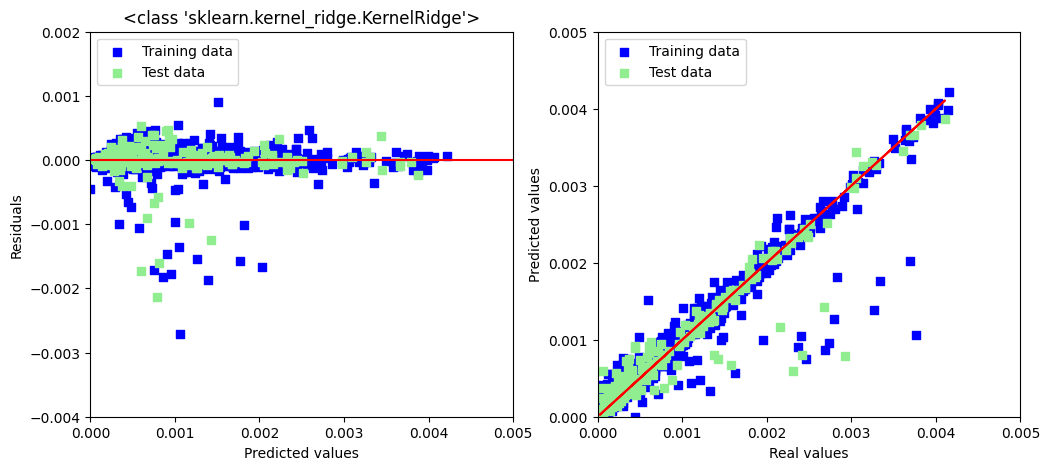

In [19]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
y_pred_t=plot_a(KernelRidge,estKR)

ax2= plt.subplot(122)
plot_b(y_pred_t)

## <a name="C13">4-2-3 Régularisation Lasso</a>

In [20]:
time_1=time.time()
(estLA, y_pred,LA,mae_LA)=regression(Lasso,{'alpha':np.logspace(-3, 6, 200)})
time_LA=time.time()-time_1

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................alpha=0.0011097524964120721; total time=   0.0s
[CV] END ........................alpha=0.0011097524964120721; total time=   0.0s
[CV] END ........................alpha=0.0011097524964120721; total time=   0.0s
[CV] END ........................alpha=0.0011097524964120721; total time=   0.0s
[CV] END ........................alpha=0.0011097524964120721; total time=   0.0s
[CV] END ........................alpha=0.0012315506032928262; total time=   0.0s
[CV] END ........................alpha=0.0012

[CV] END .........................alpha=0.020490746898158472; total time=   0.0s
[CV] END .........................alpha=0.022739657523579287; total time=   0.0s
[CV] END .........................alpha=0.022739657523579287; total time=   0.0s
[CV] END .........................alpha=0.022739657523579287; total time=   0.0s
[CV] END .........................alpha=0.022739657523579287; total time=   0.0s
[CV] END .........................alpha=0.022739657523579287; total time=   0.0s
[CV] END ..........................alpha=0.02523539170434766; total time=   0.0s
[CV] END ..........................alpha=0.02523539170434766; total time=   0.0s
[CV] END ..........................alpha=0.02523539170434766; total time=   0.0s
[CV] END ..........................alpha=0.02523539170434766; total time=   0.0s
[CV] END ..........................alpha=0.02523539170434766; total time=   0.0s
[CV] END ..........................alpha=0.02800503894183631; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.7067181273927491; total time=   0.0s
[CV] END ...........................alpha=0.7067181273927491; total time=   0.0s
[CV] END ...........................alpha=0.7067181273927491; total time=   0.0s
[CV] END ...........................alpha=0.7067181273927491; total time=   0.0s
[CV] END ...........................alpha=0.7842822061337682; total time=   0.0s
[CV] END ...........................alpha=0.7842822061337682; total time=   0.0s
[CV] END ...........................alpha=0.7842822061337682; total time=   0.0s
[CV] END ...........................alpha=0.7842822061337682; total time=   0.0s
[CV] END ...........................alpha=0.7842822061337682; total time=   0.0s
[CV] END ...........................alpha=0.8703591361485166; total time=   0.0s
[CV] END ...........................alpha=0.8703591361485166; total time=   0.0s
[CV] END ...........................alpha=0.8703591361485166; total time=   0.0s
[CV] END ...................

[CV] END ............................alpha=27.04959730463137; total time=   0.0s
[CV] END ............................alpha=27.04959730463137; total time=   0.0s
[CV] END ............................alpha=27.04959730463137; total time=   0.0s
[CV] END ............................alpha=27.04959730463137; total time=   0.0s
[CV] END ............................alpha=30.01835813575592; total time=   0.0s
[CV] END ............................alpha=30.01835813575592; total time=   0.0s
[CV] END ............................alpha=30.01835813575592; total time=   0.0s
[CV] END ............................alpha=30.01835813575592; total time=   0.0s
[CV] END ............................alpha=30.01835813575592; total time=   0.0s
[CV] END ............................alpha=33.31294787934677; total time=   0.0s
[CV] END ............................alpha=33.31294787934677; total time=   0.0s
[CV] END ............................alpha=33.31294787934677; total time=   0.0s
[CV] END ...................

[CV] END ............................alpha=932.9304026284696; total time=   0.0s
[CV] END ............................alpha=932.9304026284696; total time=   0.0s
[CV] END ............................alpha=932.9304026284696; total time=   0.0s
[CV] END ............................alpha=932.9304026284696; total time=   0.0s
[CV] END ...........................alpha=1035.3218432956637; total time=   0.0s
[CV] END ...........................alpha=1035.3218432956637; total time=   0.0s
[CV] END ...........................alpha=1035.3218432956637; total time=   0.0s
[CV] END ...........................alpha=1035.3218432956637; total time=   0.0s
[CV] END ...........................alpha=1035.3218432956637; total time=   0.0s
[CV] END ...........................alpha=1148.9510001873086; total time=   0.0s
[CV] END ...........................alpha=1148.9510001873086; total time=   0.0s
[CV] END ...........................alpha=1148.9510001873086; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=32176.417502507353; total time=   0.0s
[CV] END ...........................alpha=32176.417502507353; total time=   0.0s
[CV] END ...........................alpha=32176.417502507353; total time=   0.0s
[CV] END ...........................alpha=32176.417502507353; total time=   0.0s
[CV] END ...........................alpha=32176.417502507353; total time=   0.0s
[CV] END ...........................alpha=35707.859649004626; total time=   0.0s
[CV] END ...........................alpha=35707.859649004626; total time=   0.0s
[CV] END ...........................alpha=35707.859649004626; total time=   0.0s
[CV] END ...........................alpha=35707.859649004626; total time=   0.0s
[CV] END ...........................alpha=35707.859649004626; total time=   0.0s
[CV] END ............................alpha=39626.88638701478; total time=   0.0s
[CV] END ............................alpha=39626.88638701478; total time=   0.0s
[CV] END ...................

Régression <class 'sklearn.linear_model._coordinate_descent.Lasso'> train set score R2: 0.00, MAE: 0.00, mean_squared_error: 0.00
Régression <class 'sklearn.linear_model._coordinate_descent.Lasso'> test set score R2: -0.00, MAE: 0.00, mean_squared_error: 0.00


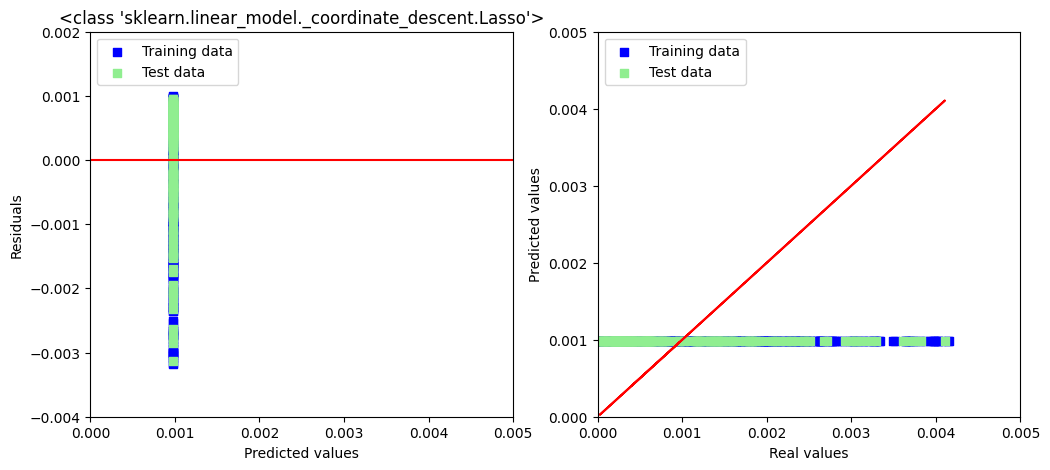

In [21]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
y_pred_t=plot_a(Lasso,estLA)

ax2= plt.subplot(122)
plot_b(y_pred_t)

<class 'sklearn.linear_model._coordinate_descent.Lasso'> picked 0 features and eliminated the other 17 features


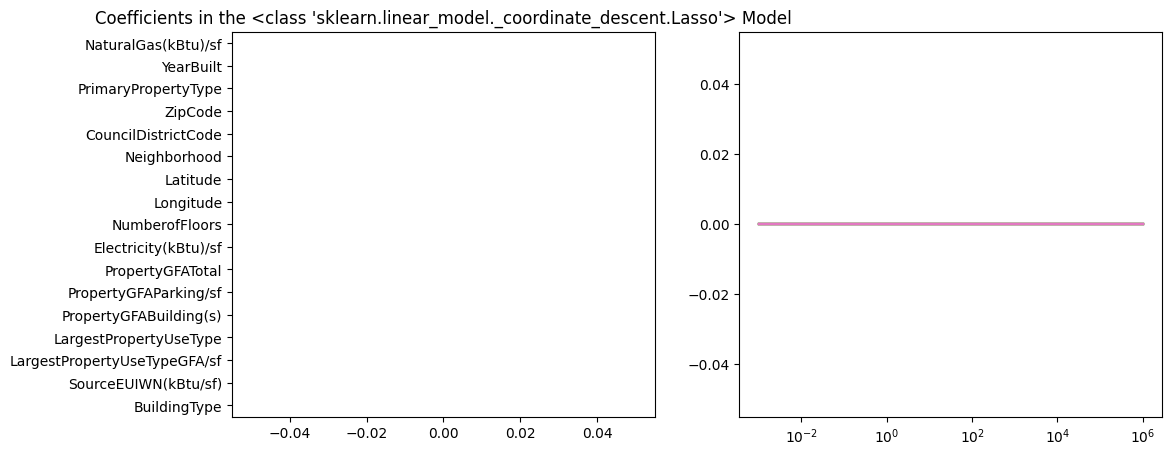

In [22]:
plt.figure(figsize=(12,5))
ax1=plt.subplot(121)
coef(estLA,Lasso)
ax2=plt.subplot(122)
evo(Lasso)
plt.show()

## <a name="C14">4-2-4 Régularisation ElasticNet</a>

In [23]:
time_1=time.time()
(estEN, y_pred,EN,mae_EN)=regression(ElasticNet,{'l1_ratio':np.linspace(0,1,2),'alpha':np.logspace(-3, 6, 200)})
time_EN=time.time()-time_1

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END ..........................alpha=0.001, l1_ratio=0.0; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.778e-05, tolerance: 5.406e-08 Linear

[CV] END ..........................alpha=0.001, l1_ratio=0.0; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=0.0; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=0.0; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=1.0; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=1.0; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=1.0; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=1.0; total time=   0.0s
[CV] END ..........................alpha=0.001, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e-05, tolerance: 5.507e-08 Linear

[CV] END ..........alpha=0.0011097524964120721, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0011097524964120721, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0011097524964120721, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0011097524964120721, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.492e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.973e-05, tolerance: 5.547e-08 Linear

[CV] END ..........alpha=0.0011097524964120721, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0011097524964120721, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0011097524964120721, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0011097524964120721, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0011097524964120721, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0011097524964120721, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0012315506032928262, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0012315506032928262, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0012315506032928262, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.783e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e-05, tolerance: 5.441e-08 Linear

[CV] END ..........alpha=0.0012315506032928262, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0012315506032928262, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0012315506032928262, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0012315506032928262, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0012315506032928262, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0012315506032928262, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0012315506032928262, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.001366716356462006, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.387e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.786e-05, tolerance: 5.406e-08 Linear

[CV] END ...........alpha=0.001366716356462006, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.001366716356462006, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.001366716356462006, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.391e-05, tolerance: 5.507e-08 Linear

[CV] END ...........alpha=0.001366716356462006, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.001366716356462006, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.001366716356462006, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.001366716356462006, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.001366716356462006, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.001366716356462006, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0015167168884709225, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0015167168884709225, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0015167168884709225, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e-05, tolerance: 5.441e-08 Linear

[CV] END ..........alpha=0.0015167168884709225, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0015167168884709225, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0015167168884709225, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0015167168884709225, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0015167168884709225, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0015167168884709225, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0015167168884709225, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0016831803533309566, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0016831803533309566, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.506e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.987e-05, tolerance: 5.547e-08 Linear

[CV] END ..........alpha=0.0016831803533309566, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0016831803533309566, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0016831803533309566, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0016831803533309566, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0016831803533309566, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0016831803533309566, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0016831803533309566, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0016831803533309566, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0018679135990207828, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.797e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.510e-05, tolerance: 5.441e-08 Linear

[CV] END ..........alpha=0.0018679135990207828, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0018679135990207828, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0018679135990207828, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0018679135990207828, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0018679135990207828, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0018679135990207828, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0018679135990207828, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0018679135990207828, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0018679135990207828, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.403e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.802e-05, tolerance: 5.406e-08 Linear

[CV] END ...........alpha=0.002072921779595372, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002072921779595372, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002072921779595372, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002072921779595372, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.311e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.408e-05, tolerance: 5.507e-08 Linear

[CV] END ...........alpha=0.002072921779595372, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002072921779595372, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002072921779595372, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002072921779595372, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002072921779595372, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002072921779595372, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002300430119772917, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002300430119772917, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.520e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.002e-05, tolerance: 5.547e-08 Linear

[CV] END ...........alpha=0.002300430119772917, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002300430119772917, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002300430119772917, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002300430119772917, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002300430119772917, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002300430119772917, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002300430119772917, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002300430119772917, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0025529080682395165, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.813e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.526e-05, tolerance: 5.441e-08 Linear

[CV] END ..........alpha=0.0025529080682395165, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0025529080682395165, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0025529080682395165, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0025529080682395165, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0025529080682395165, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0025529080682395165, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0025529080682395165, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0025529080682395165, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0025529080682395165, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.420e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.819e-05, tolerance: 5.406e-08 Linear

[CV] END ...........alpha=0.002833096101839324, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002833096101839324, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002833096101839324, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002833096101839324, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.329e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.427e-05, tolerance: 5.507e-08 Linear

[CV] END ...........alpha=0.002833096101839324, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.002833096101839324, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002833096101839324, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002833096101839324, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002833096101839324, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.002833096101839324, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.0031440354715915, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.0031440354715915, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.0031440354715915, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.022e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e-05, tolerance: 5.441e-08 Linear

[CV] END .............alpha=0.0031440354715915, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.0031440354715915, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.0031440354715915, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.0031440354715915, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.0031440354715915, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.0031440354715915, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.0031440354715915, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0034891012134067737, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.833e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.548e-05, tolerance: 5.441e-08 Linear

[CV] END ..........alpha=0.0034891012134067737, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0034891012134067737, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0034891012134067737, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0034891012134067737, l1_ratio=0.0; total time=   0.0s
[CV] END ..........alpha=0.0034891012134067737, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0034891012134067737, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0034891012134067737, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0034891012134067737, l1_ratio=1.0; total time=   0.0s
[CV] END ..........alpha=0.0034891012134067737, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.003872038781812557, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.003872038781812557, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.003872038781812557, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.443e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.842e-05, tolerance: 5.406e-08 Linear

[CV] END ...........alpha=0.003872038781812557, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.003872038781812557, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.003872038781812557, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.003872038781812557, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.003872038781812557, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.003872038781812557, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.003872038781812557, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.004297004704320844, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.004297004704320844, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.452e-05, tolerance: 5.507e-08 Linear

[CV] END ...........alpha=0.004297004704320844, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.004297004704320844, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.004297004704320844, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.004297004704320844, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.004297004704320844, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.004297004704320844, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.004297004704320844, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.004297004704320844, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.463e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.862e-05, tolerance: 5.406e-08 Linear

[CV] END ...........alpha=0.004768611697714469, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.004768611697714469, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.004768611697714469, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.004768611697714469, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.373e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.474e-05, tolerance: 5.507e-08 Linear

[CV] END ...........alpha=0.004768611697714469, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.004768611697714469, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.004768611697714469, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.004768611697714469, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.004768611697714469, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.004768611697714469, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.005291978735958442, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.005291978735958442, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.005291978735958442, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.385e-05, tolerance: 5.441e-08 Linear

[CV] END ...........alpha=0.005291978735958442, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.005291978735958442, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.005291978735958442, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.005291978735958442, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.005291978735958442, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.005291978735958442, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.005291978735958442, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.005872786613189483, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.005872786613189483, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.603e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e-05, tolerance: 5.547e-08 Linear

[CV] END ...........alpha=0.005872786613189483, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.005872786613189483, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.005872786613189483, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.005872786613189483, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.005872786613189483, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.005872786613189483, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.005872786613189483, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.005872786613189483, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.00651733960488242, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.900e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.618e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.00651733960488242, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.00651733960488242, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.00651733960488242, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.517e-05, tolerance: 5.507e-08 Linear

[CV] END ............alpha=0.00651733960488242, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.00651733960488242, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.00651733960488242, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.00651733960488242, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.00651733960488242, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.00651733960488242, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.007232633896483534, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.007232633896483534, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.007232633896483534, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.428e-05, tolerance: 5.441e-08 Linear

[CV] END ...........alpha=0.007232633896483534, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.007232633896483534, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.007232633896483534, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.007232633896483534, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.007232633896483534, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.007232633896483534, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.007232633896483534, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.008026433522257174, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.008026433522257174, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e-05, tolerance: 5.547e-08 Linear

[CV] END ...........alpha=0.008026433522257174, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.008026433522257174, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.008026433522257174, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.008026433522257174, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.008026433522257174, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.008026433522257174, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.008026433522257174, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.008026433522257174, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.554e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.952e-05, tolerance: 5.406e-08 Linear

[CV] END ............alpha=0.00890735463861044, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.00890735463861044, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.00890735463861044, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.00890735463861044, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.466e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.575e-05, tolerance: 5.507e-08 Linear

[CV] END ............alpha=0.00890735463861044, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.00890735463861044, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.00890735463861044, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.00890735463861044, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.00890735463861044, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.00890735463861044, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.009884959046625586, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.009884959046625586, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.694e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e-05, tolerance: 5.547e-08 Linear

[CV] END ...........alpha=0.009884959046625586, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.009884959046625586, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.009884959046625586, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.009884959046625586, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.009884959046625586, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.009884959046625586, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.009884959046625586, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.009884959046625586, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.599e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.997e-05, tolerance: 5.406e-08 Linear

[CV] END ...........alpha=0.010969857978923836, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.010969857978923836, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.010969857978923836, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.010969857978923836, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.625e-05, tolerance: 5.507e-08 Linear

[CV] END ...........alpha=0.010969857978923836, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.010969857978923836, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.010969857978923836, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.010969857978923836, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.010969857978923836, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.010969857978923836, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.012173827277396614, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.012173827277396614, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.234e-05, tolerance: 5.547e-08 Linear

[CV] END ...........alpha=0.012173827277396614, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.012173827277396614, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.012173827277396614, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.012173827277396614, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.012173827277396614, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.012173827277396614, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.012173827277396614, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.012173827277396614, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.013509935211980273, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.052e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.776e-05, tolerance: 5.441e-08 Linear

[CV] END ...........alpha=0.013509935211980273, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.013509935211980273, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.013509935211980273, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.013509935211980273, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.013509935211980273, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.013509935211980273, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.013509935211980273, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.013509935211980273, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.013509935211980273, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.686e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.084e-05, tolerance: 5.406e-08 Linear

[CV] END ...........alpha=0.014992684327860457, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.014992684327860457, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.014992684327860457, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.014992684327860457, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.600e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-05, tolerance: 5.507e-08 Linear

[CV] END ...........alpha=0.014992684327860457, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.014992684327860457, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.014992684327860457, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.014992684327860457, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.014992684327860457, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.014992684327860457, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.01663816886076129, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.01663816886076129, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.01663816886076129, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.01663816886076129, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.01663816886076129, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.01663816886076129, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.01663816886076129, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.01663816886076129, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.01663816886076129, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.01663816886076129, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.018464249428955443, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.018464249428955443, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.887e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.378e-05, tolerance: 5.547e-08 Linear

[CV] END ...........alpha=0.018464249428955443, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.018464249428955443, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.018464249428955443, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.018464249428955443, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.018464249428955443, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.018464249428955443, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.018464249428955443, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.018464249428955443, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.020490746898158472, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.201e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.932e-05, tolerance: 5.441e-08 Linear

[CV] END ...........alpha=0.020490746898158472, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.020490746898158472, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.020490746898158472, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.020490746898158472, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.020490746898158472, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.020490746898158472, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.020490746898158472, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.020490746898158472, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.020490746898158472, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.022739657523579287, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.022739657523579287, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.022739657523579287, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.850e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.248e-05, tolerance: 5.406e-08 Linear

[CV] END ...........alpha=0.022739657523579287, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.022739657523579287, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.022739657523579287, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.022739657523579287, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.022739657523579287, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.022739657523579287, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.022739657523579287, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.02523539170434766, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.767e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.903e-05, tolerance: 5.507e-08 Linear

[CV] END ............alpha=0.02523539170434766, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.02523539170434766, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.02523539170434766, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.02523539170434766, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.02523539170434766, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.02523539170434766, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.02523539170434766, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.529e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.819e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.02523539170434766, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.02523539170434766, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.02800503894183631, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.02800503894183631, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.02800503894183631, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.02800503894183631, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.02800503894183631, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.02800503894183631, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.02800503894183631, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.02800503894183631, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.02800503894183631, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.02800503894183631, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.03107866187782014, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.024e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.421e-05, tolerance: 5.406e-08 Linear

[CV] END ............alpha=0.03107866187782014, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.03107866187782014, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.03107866187782014, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.941e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.094e-05, tolerance: 5.507e-08 Linear

[CV] END ............alpha=0.03107866187782014, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.03107866187782014, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.03107866187782014, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.03107866187782014, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.03107866187782014, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.03107866187782014, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.03448962260405758, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.03448962260405758, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.03448962260405758, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.731e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.012e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.03448962260405758, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.03448962260405758, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.03448962260405758, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.03448962260405758, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.03448962260405758, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.03448962260405758, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.03448962260405758, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.038274944785163134, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.568e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e-05, tolerance: 5.441e-08 Linear

[CV] END ...........alpha=0.038274944785163134, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.038274944785163134, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.038274944785163134, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.038274944785163134, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.038274944785163134, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.038274944785163134, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.038274944785163134, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.038274944785163134, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.038274944785163134, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.04247571552536898, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.04247571552536898, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.04247571552536898, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.652e-05, tolerance: 5.406e-08 Linear

[CV] END ............alpha=0.04247571552536898, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.04247571552536898, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.04247571552536898, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.04247571552536898, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.04247571552536898, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.04247571552536898, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.04247571552536898, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.047137531341167244, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.047137531341167244, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.173e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.349e-05, tolerance: 5.507e-08 Linear

[CV] END ...........alpha=0.047137531341167244, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.047137531341167244, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.047137531341167244, l1_ratio=0.0; total time=   0.0s
[CV] END ...........alpha=0.047137531341167244, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.047137531341167244, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.047137531341167244, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.047137531341167244, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.047137531341167244, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.998e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.266e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.05231099308056263, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.05231099308056263, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.05231099308056263, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.05231099308056263, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.605e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.105e-05, tolerance: 5.547e-08 Linear

[CV] END ............alpha=0.05231099308056263, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.05231099308056263, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.05231099308056263, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.05231099308056263, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.05231099308056263, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.05231099308056263, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.05805225516094899, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.05805225516094899, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.05805225516094899, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.562e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.956e-05, tolerance: 5.406e-08 Linear

[CV] END ............alpha=0.05805225516094899, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.05805225516094899, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.05805225516094899, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.05805225516094899, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.05805225516094899, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.05805225516094899, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.05805225516094899, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.06442363508721373, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.479e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.684e-05, tolerance: 5.507e-08 Linear

[CV] END ............alpha=0.06442363508721373, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.06442363508721373, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.06442363508721373, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.349e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.601e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.06442363508721373, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.06442363508721373, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.06442363508721373, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.06442363508721373, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.06442363508721373, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.06442363508721373, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.07149428986597581, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.07149428986597581, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.07149428986597581, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.986e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.487e-05, tolerance: 5.547e-08 Linear

[CV] END ............alpha=0.07149428986597581, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.07149428986597581, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.07149428986597581, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.07149428986597581, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.07149428986597581, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.07149428986597581, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.07149428986597581, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.07934096665797492, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.355e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.138e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.07934096665797492, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.07934096665797492, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.07934096665797492, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.07934096665797492, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.07934096665797492, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.07934096665797492, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.07934096665797492, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.07934096665797492, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.07934096665797492, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.123e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.512e-05, tolerance: 5.406e-08 Linear

[CV] END ............alpha=0.08804883581643465, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.08804883581643465, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.08804883581643465, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.08804883581643465, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.035e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.296e-05, tolerance: 5.507e-08 Linear

[CV] END ............alpha=0.08804883581643465, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.08804883581643465, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.08804883581643465, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.08804883581643465, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.08804883581643465, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.08804883581643465, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09771241535346502, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.09771241535346502, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.481e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.981e-05, tolerance: 5.547e-08 Linear

[CV] END ............alpha=0.09771241535346502, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.09771241535346502, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.09771241535346502, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.09771241535346502, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09771241535346502, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09771241535346502, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09771241535346502, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09771241535346502, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.483e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.868e-05, tolerance: 5.406e-08 Linear

[CV] END .............alpha=0.1084365968689611, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.1084365968689611, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.1084365968689611, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.1084365968689611, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.392e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.687e-05, tolerance: 5.507e-08 Linear

[CV] END .............alpha=0.1084365968689611, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.1084365968689611, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.1084365968689611, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.1084365968689611, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.1084365968689611, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.1084365968689611, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.12033778407775893, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.12033778407775893, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.886e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.384e-05, tolerance: 5.547e-08 Linear

[CV] END ............alpha=0.12033778407775893, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.12033778407775893, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.12033778407775893, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.12033778407775893, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.12033778407775893, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.12033778407775893, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.12033778407775893, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.12033778407775893, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.13354515629298988, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.285e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.113e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.13354515629298988, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.13354515629298988, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.13354515629298988, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.13354515629298988, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.13354515629298988, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.13354515629298988, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.13354515629298988, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.13354515629298988, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.13354515629298988, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.14820207057988585, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.14820207057988585, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.14820207057988585, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.145e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.518e-05, tolerance: 5.406e-08 Linear

[CV] END ............alpha=0.14820207057988585, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.14820207057988585, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.14820207057988585, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.14820207057988585, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.14820207057988585, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.14820207057988585, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.14820207057988585, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.16446761779946645, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.16446761779946645, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.044e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.400e-05, tolerance: 5.507e-08 Linear

[CV] END ............alpha=0.16446761779946645, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.16446761779946645, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.16446761779946645, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.16446761779946645, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.16446761779946645, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.16446761779946645, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.16446761779946645, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.16446761779946645, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.675e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.038e-05, tolerance: 5.406e-08 Linear

[CV] END ............alpha=0.18251834943190443, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.18251834943190443, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.18251834943190443, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.392e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.567e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.18251834943190443, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.18251834943190443, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.18251834943190443, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.18251834943190443, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.18251834943190443, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.18251834943190443, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.18251834943190443, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.20255019392306664, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.326e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.208e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.20255019392306664, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.20255019392306664, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.20255019392306664, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.20255019392306664, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.20255019392306664, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.20255019392306664, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.20255019392306664, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.20255019392306664, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.20255019392306664, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.22478058335487253, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.22478058335487253, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.284e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.633e-05, tolerance: 5.406e-08 Linear

[CV] END ............alpha=0.22478058335487253, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.22478058335487253, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.22478058335487253, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.22478058335487253, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.22478058335487253, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.22478058335487253, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.22478058335487253, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.22478058335487253, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.010e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.165e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.24945081352303167, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.24945081352303167, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.24945081352303167, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.24945081352303167, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.959e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.876e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.24945081352303167, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.24945081352303167, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.24945081352303167, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.24945081352303167, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.24945081352303167, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.24945081352303167, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.27682866303920667, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.27682866303920667, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.241e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.707e-05, tolerance: 5.547e-08 Linear

[CV] END ............alpha=0.27682866303920667, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.27682866303920667, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.27682866303920667, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.27682866303920667, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.27682866303920667, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.27682866303920667, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.27682866303920667, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.27682866303920667, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.351e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.670e-05, tolerance: 5.406e-08 Linear

[CV] END .............alpha=0.3072112998861759, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.3072112998861759, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.3072112998861759, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.087e-05, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.211e-05, tolerance: 5.441e-08 Linear

[CV] END .............alpha=0.3072112998861759, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.3072112998861759, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.3072112998861759, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.3072112998861759, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.3072112998861759, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.3072112998861759, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.3072112998861759, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.34092850697468147, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.055e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.034e-05, tolerance: 5.441e-08 Linear

[CV] END ............alpha=0.34092850697468147, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.34092850697468147, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.34092850697468147, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.600e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.166e-05, tolerance: 5.507e-08 Linear

[CV] END ............alpha=0.34092850697468147, l1_ratio=0.0; total time=   0.0s
[CV] END ............alpha=0.34092850697468147, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.34092850697468147, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.34092850697468147, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.34092850697468147, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.34092850697468147, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.3783462617131929, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.3783462617131929, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.461e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.905e-05, tolerance: 5.547e-08 Linear

[CV] END .............alpha=0.3783462617131929, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.3783462617131929, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.3783462617131929, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.3783462617131929, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.3783462617131929, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.3783462617131929, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.3783462617131929, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.3783462617131929, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=0.419870708444391, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.881e-05, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.908e-05, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=0.419870708444391, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=0.419870708444391, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=0.419870708444391, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=0.419870708444391, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=0.419870708444391, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=0.419870708444391, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=0.419870708444391, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=0.419870708444391, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=0.419870708444391, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.4659525668664682, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.4659525668664682, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.4659525668664682, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.062e-05, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.322e-05, tolerance: 5.406e-08 Linear

[CV] END .............alpha=0.4659525668664682, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.4659525668664682, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.4659525668664682, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.4659525668664682, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.4659525668664682, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.4659525668664682, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.4659525668664682, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=0.517092024289676, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.882e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.539e-05, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=0.517092024289676, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=0.517092024289676, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=0.517092024289676, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=0.517092024289676, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.859e-05, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.028e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=0.517092024289676, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=0.517092024289676, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=0.517092024289676, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=0.517092024289676, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=0.517092024289676, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.5738441648302398, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.5738441648302398, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.5738441648302398, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.003e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=0.5738441648302398, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.5738441648302398, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.5738441648302398, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.5738441648302398, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.5738441648302398, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.5738441648302398, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.5738441648302398, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.6368249944718586, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.6368249944718586, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.083e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=0.6368249944718586, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.6368249944718586, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.6368249944718586, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.6368249944718586, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.6368249944718586, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.6368249944718586, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.6368249944718586, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.6368249944718586, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.107e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=0.7067181273927491, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.7067181273927491, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.7067181273927491, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.180e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.183e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=0.7067181273927491, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.7067181273927491, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.7067181273927491, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.7067181273927491, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.7067181273927491, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.7067181273927491, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.7067181273927491, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.7842822061337682, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=0.7842822061337682, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.7842822061337682, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.7842822061337682, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.7842822061337682, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.7842822061337682, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.7842822061337682, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.7842822061337682, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.7842822061337682, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.7842822061337682, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.216e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=0.8703591361485166, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.8703591361485166, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.8703591361485166, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.8703591361485166, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=0.8703591361485166, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.8703591361485166, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.8703591361485166, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.8703591361485166, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.8703591361485166, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.8703591361485166, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9658832241158708, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.9658832241158708, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=0.9658832241158708, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.9658832241158708, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.9658832241158708, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=0.9658832241158708, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9658832241158708, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9658832241158708, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9658832241158708, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9658832241158708, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.337e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=1.0718913192051276, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.0718913192051276, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.0718913192051276, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.398e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=1.0718913192051276, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.0718913192051276, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.0718913192051276, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.0718913192051276, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.0718913192051276, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.0718913192051276, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.0718913192051276, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.1895340673703196, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=1.1895340673703196, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.1895340673703196, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.1895340673703196, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.1895340673703196, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.1895340673703196, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.1895340673703196, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.1895340673703196, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.1895340673703196, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.1895340673703196, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=1.3200884008314182, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.3200884008314182, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.3200884008314182, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.3200884008314182, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=1.3200884008314182, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.3200884008314182, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.3200884008314182, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.3200884008314182, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.3200884008314182, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.3200884008314182, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.4649713983072863, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.4649713983072863, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.4649713983072863, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=1.4649713983072863, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.4649713983072863, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.4649713983072863, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.4649713983072863, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.4649713983072863, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.4649713983072863, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.4649713983072863, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1.625755666443795, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.595e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=1.625755666443795, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1.625755666443795, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1.625755666443795, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1.625755666443795, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1.625755666443795, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1.625755666443795, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1.625755666443795, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1.625755666443795, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1.625755666443795, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.613e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=1.8041864093920719, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.8041864093920719, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.8041864093920719, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.8041864093920719, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.676e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=1.8041864093920719, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1.8041864093920719, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.8041864093920719, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.8041864093920719, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.8041864093920719, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1.8041864093920719, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.0022003718155843, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.0022003718155843, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.709e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.741e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=2.0022003718155843, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.0022003718155843, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.0022003718155843, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.0022003718155843, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.0022003718155843, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.0022003718155843, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.0022003718155843, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.0022003718155843, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=2.2219468609395236, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.2219468609395236, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.2219468609395236, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=2.2219468609395236, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.2219468609395236, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.2219468609395236, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.2219468609395236, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.2219468609395236, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.2219468609395236, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.2219468609395236, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.4658110758226037, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=2.4658110758226037, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.4658110758226037, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.4658110758226037, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.4658110758226037, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2.4658110758226037, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.4658110758226037, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.4658110758226037, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.4658110758226037, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2.4658110758226037, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=2.736439997074672, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=2.736439997074672, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=2.736439997074672, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=2.736439997074672, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=2.736439997074672, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=2.736439997074672, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=2.736439997074672, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=2.736439997074672, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=2.736439997074672, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=2.736439997074672, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3.0367711180354604, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=3.0367711180354604, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3.0367711180354604, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3.0367711180354604, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=3.0367711180354604, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3.0367711180354604, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3.0367711180354604, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3.0367711180354604, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3.0367711180354604, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3.0367711180354604, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=3.370064329271928, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=3.370064329271928, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=3.370064329271928, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=3.370064329271928, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=3.370064329271928, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=3.370064329271928, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=3.370064329271928, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=3.370064329271928, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=3.370064329271928, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=3.370064329271928, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=3.739937302478798, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=3.739937302478798, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=3.739937302478798, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=3.739937302478798, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.056e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=3.739937302478798, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=3.739937302478798, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=3.739937302478798, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=3.739937302478798, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=3.739937302478798, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=3.739937302478798, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4.150404757850477, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4.150404757850477, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4.150404757850477, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=4.150404757850477, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4.150404757850477, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4.150404757850477, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4.150404757850477, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4.150404757850477, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4.150404757850477, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4.150404757850477, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4.605922041145108, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.071e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.117e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=4.605922041145108, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4.605922041145108, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4.605922041145108, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.127e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.147e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=4.605922041145108, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4.605922041145108, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4.605922041145108, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4.605922041145108, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4.605922041145108, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4.605922041145108, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=5.1114334834401705, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=5.1114334834401705, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.193e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=5.1114334834401705, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=5.1114334834401705, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=5.1114334834401705, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=5.1114334834401705, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=5.1114334834401705, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=5.1114334834401705, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=5.1114334834401705, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=5.1114334834401705, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.156e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=5.672426068491977, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=5.672426068491977, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=5.672426068491977, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.235e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.209e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=5.672426068491977, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=5.672426068491977, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=5.672426068491977, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=5.672426068491977, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=5.672426068491977, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=5.672426068491977, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=5.672426068491977, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6.294988990221888, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.196e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.241e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=6.294988990221888, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6.294988990221888, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6.294988990221888, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.247e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.272e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=6.294988990221888, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6.294988990221888, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6.294988990221888, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6.294988990221888, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6.294988990221888, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6.294988990221888, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6.985879746785249, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6.985879746785249, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.313e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=6.985879746785249, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6.985879746785249, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6.985879746785249, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6.985879746785249, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6.985879746785249, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6.985879746785249, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6.985879746785249, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6.985879746785249, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=7.752597488629465, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=7.752597488629465, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=7.752597488629465, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=7.752597488629465, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.344e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=7.752597488629465, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=7.752597488629465, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=7.752597488629465, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=7.752597488629465, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=7.752597488629465, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=7.752597488629465, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=8.60346441668451, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=8.60346441668451, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=8.60346441668451, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.349e-04, tolerance: 5.441e-08 Linear

[CV] END ...............alpha=8.60346441668451, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=8.60346441668451, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=8.60346441668451, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=8.60346441668451, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=8.60346441668451, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=8.60346441668451, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=8.60346441668451, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=9.547716114208066, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.335e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.375e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=9.547716114208066, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=9.547716114208066, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=9.547716114208066, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.380e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.407e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=9.547716114208066, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=9.547716114208066, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=9.547716114208066, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=9.547716114208066, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=9.547716114208066, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=9.547716114208066, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=10.59560179277617, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=10.59560179277617, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.404e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.443e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=10.59560179277617, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=10.59560179277617, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=10.59560179277617, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=10.59560179277617, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=10.59560179277617, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=10.59560179277617, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=10.59560179277617, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=10.59560179277617, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.436e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.393e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=11.758495540521581, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=11.758495540521581, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=11.758495540521581, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=11.758495540521581, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.434e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.463e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=11.758495540521581, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=11.758495540521581, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=11.758495540521581, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=11.758495540521581, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=11.758495540521581, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=11.758495540521581, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=13.049019780144016, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=13.049019780144016, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.455e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.496e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=13.049019780144016, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=13.049019780144016, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=13.049019780144016, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=13.049019780144016, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=13.049019780144016, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=13.049019780144016, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=13.049019780144016, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=13.049019780144016, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.488e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.443e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=14.481182276745331, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=14.481182276745331, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=14.481182276745331, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.520e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.481e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=14.481182276745331, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=14.481182276745331, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=14.481182276745331, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=14.481182276745331, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=14.481182276745331, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=14.481182276745331, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=14.481182276745331, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=16.070528182616385, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.465e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.499e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=16.070528182616385, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=16.070528182616385, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=16.070528182616385, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=16.070528182616385, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=16.070528182616385, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=16.070528182616385, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=16.070528182616385, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=16.070528182616385, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=16.070528182616385, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.532e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.486e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=17.834308769319094, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=17.834308769319094, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=17.834308769319094, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.562e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=17.834308769319094, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=17.834308769319094, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=17.834308769319094, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=17.834308769319094, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=17.834308769319094, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=17.834308769319094, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=17.834308769319094, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=19.791668678535572, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.505e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.537e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=19.791668678535572, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=19.791668678535572, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=19.791668678535572, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=19.791668678535572, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=19.791668678535572, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=19.791668678535572, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=19.791668678535572, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=19.791668678535572, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=19.791668678535572, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=21.96385372416547, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=21.96385372416547, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.570e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.523e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=21.96385372416547, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=21.96385372416547, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=21.96385372416547, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=21.96385372416547, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=21.96385372416547, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=21.96385372416547, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=21.96385372416547, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=21.96385372416547, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.555e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.586e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=24.37444150122222, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=24.37444150122222, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=24.37444150122222, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.569e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.614e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=24.37444150122222, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=24.37444150122222, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=24.37444150122222, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=24.37444150122222, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=24.37444150122222, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=24.37444150122222, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=24.37444150122222, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=27.04959730463137, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.554e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=27.04959730463137, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=27.04959730463137, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=27.04959730463137, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.584e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.615e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=27.04959730463137, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=27.04959730463137, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=27.04959730463137, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=27.04959730463137, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=27.04959730463137, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=27.04959730463137, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=30.01835813575592, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=30.01835813575592, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=30.01835813575592, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.642e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.596e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=30.01835813575592, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=30.01835813575592, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=30.01835813575592, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=30.01835813575592, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=30.01835813575592, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=30.01835813575592, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=30.01835813575592, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=33.31294787934677, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.580e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.607e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=33.31294787934677, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=33.31294787934677, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=33.31294787934677, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.640e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=33.31294787934677, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=33.31294787934677, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=33.31294787934677, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=33.31294787934677, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=33.31294787934677, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=33.31294787934677, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=36.96912707195032, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=36.96912707195032, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.617e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.665e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=36.96912707195032, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=36.96912707195032, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=36.96912707195032, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=36.96912707195032, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=36.96912707195032, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=36.96912707195032, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=36.96912707195032, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=36.96912707195032, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.651e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e-04, tolerance: 5.406e-08 Linear

[CV] END ...............alpha=41.0265810582719, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=41.0265810582719, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=41.0265810582719, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=41.0265810582719, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.660e-04, tolerance: 5.507e-08 Linear

[CV] END ...............alpha=41.0265810582719, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=41.0265810582719, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=41.0265810582719, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=41.0265810582719, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=41.0265810582719, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=41.0265810582719, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=45.52935074866948, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=45.52935074866948, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.636e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.684e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=45.52935074866948, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=45.52935074866948, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=45.52935074866948, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=45.52935074866948, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=45.52935074866948, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=45.52935074866948, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=45.52935074866948, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=45.52935074866948, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.669e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.620e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=50.526310653356795, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=50.526310653356795, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=50.526310653356795, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=50.526310653356795, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.645e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.677e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=50.526310653356795, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=50.526310653356795, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=50.526310653356795, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=50.526310653356795, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=50.526310653356795, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=50.526310653356795, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=56.07169938205458, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=56.07169938205458, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.651e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.701e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=56.07169938205458, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=56.07169938205458, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=56.07169938205458, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=56.07169938205458, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=56.07169938205458, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=56.07169938205458, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=56.07169938205458, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=56.07169938205458, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.684e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.635e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=62.22570836730231, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=62.22570836730231, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=62.22570836730231, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=62.22570836730231, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.659e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.691e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=62.22570836730231, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=62.22570836730231, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=62.22570836730231, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=62.22570836730231, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=62.22570836730231, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=62.22570836730231, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=69.0551352016233, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=69.0551352016233, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.714e-04, tolerance: 5.547e-08 Linear

[CV] END ...............alpha=69.0551352016233, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=69.0551352016233, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=69.0551352016233, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=69.0551352016233, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=69.0551352016233, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=69.0551352016233, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=69.0551352016233, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=69.0551352016233, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=76.63410868007462, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=76.63410868007462, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=76.63410868007462, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=76.63410868007462, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.670e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=76.63410868007462, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=76.63410868007462, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=76.63410868007462, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=76.63410868007462, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=76.63410868007462, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=76.63410868007462, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=85.04489341802686, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=85.04489341802686, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=85.04489341802686, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.725e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.675e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=85.04489341802686, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=85.04489341802686, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=85.04489341802686, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=85.04489341802686, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=85.04489341802686, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=85.04489341802686, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=85.04489341802686, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=94.37878277775391, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.657e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.679e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=94.37878277775391, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=94.37878277775391, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=94.37878277775391, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=94.37878277775391, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=94.37878277775391, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=94.37878277775391, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=94.37878277775391, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=94.37878277775391, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=94.37878277775391, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=104.73708979594508, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=104.73708979594508, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=104.73708979594508, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=104.73708979594508, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=104.73708979594508, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=104.73708979594508, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=104.73708979594508, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=104.73708979594508, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=104.73708979594508, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=104.73708979594508, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=116.23224686798542, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=116.23224686798542, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.683e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=116.23224686798542, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=116.23224686798542, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=116.23224686798542, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=116.23224686798542, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=116.23224686798542, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=116.23224686798542, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=116.23224686798542, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=116.23224686798542, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.738e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.687e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=128.9890261253308, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=128.9890261253308, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=128.9890261253308, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=128.9890261253308, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.690e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.741e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=128.9890261253308, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=128.9890261253308, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=128.9890261253308, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=128.9890261253308, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=128.9890261253308, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=128.9890261253308, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=143.14589375234786, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=143.14589375234786, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.723e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.673e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=143.14589375234786, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=143.14589375234786, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=143.14589375234786, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=143.14589375234786, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=143.14589375234786, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=143.14589375234786, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=143.14589375234786, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=143.14589375234786, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=158.85651294280527, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.693e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.726e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=158.85651294280527, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=158.85651294280527, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=158.85651294280527, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=158.85651294280527, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=158.85651294280527, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=158.85651294280527, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.747e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.696e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=158.85651294280527, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=158.85651294280527, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=158.85651294280527, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=176.2914118095948, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=176.2914118095948, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.678e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.698e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=176.2914118095948, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=176.2914118095948, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=176.2914118095948, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=176.2914118095948, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=176.2914118095948, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=176.2914118095948, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=176.2914118095948, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=176.2914118095948, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.731e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.681e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=195.63983435170647, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=195.63983435170647, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=195.63983435170647, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=195.63983435170647, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.700e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.733e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=195.63983435170647, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=195.63983435170647, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=195.63983435170647, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=195.63983435170647, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=195.63983435170647, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=195.63983435170647, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=217.11179456945052, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=217.11179456945052, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=217.11179456945052, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.754e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=217.11179456945052, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=217.11179456945052, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=217.11179456945052, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=217.11179456945052, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=217.11179456945052, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=217.11179456945052, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=217.11179456945052, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=240.9403560239527, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.685e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.704e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=240.9403560239527, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=240.9403560239527, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=240.9403560239527, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.704e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.737e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=240.9403560239527, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=240.9403560239527, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=240.9403560239527, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=240.9403560239527, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=240.9403560239527, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=240.9403560239527, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=267.38416158399497, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=267.38416158399497, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.705e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.758e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=267.38416158399497, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=267.38416158399497, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=267.38416158399497, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=267.38416158399497, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=267.38416158399497, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=267.38416158399497, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=267.38416158399497, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=267.38416158399497, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.688e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=296.73024081888724, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=296.73024081888724, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=296.73024081888724, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=296.73024081888724, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.707e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.740e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=296.73024081888724, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=296.73024081888724, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=296.73024081888724, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=296.73024081888724, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=296.73024081888724, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=296.73024081888724, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=329.2971255097155, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=329.2971255097155, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.708e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.761e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=329.2971255097155, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=329.2971255097155, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=329.2971255097155, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=329.2971255097155, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=329.2971255097155, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=329.2971255097155, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=329.2971255097155, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=329.2971255097155, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.741e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.691e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=365.43830709572546, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=365.43830709572546, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=365.43830709572546, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.762e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.710e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=365.43830709572546, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=365.43830709572546, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=365.43830709572546, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=365.43830709572546, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=365.43830709572546, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=365.43830709572546, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=365.43830709572546, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=405.54607358408276, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=405.54607358408276, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.710e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.763e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=405.54607358408276, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=405.54607358408276, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=405.54607358408276, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=405.54607358408276, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=405.54607358408276, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=405.54607358408276, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=405.54607358408276, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=405.54607358408276, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.744e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.693e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=450.05576757004974, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=450.05576757004974, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=450.05576757004974, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=450.05576757004974, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.745e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=450.05576757004974, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=450.05576757004974, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=450.05576757004974, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=450.05576757004974, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=450.05576757004974, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=450.05576757004974, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=499.450511585514, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=499.450511585514, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.765e-04, tolerance: 5.547e-08 Linear

[CV] END ...............alpha=499.450511585514, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=499.450511585514, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=499.450511585514, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=499.450511585514, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=499.450511585514, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=499.450511585514, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=499.450511585514, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=499.450511585514, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.745e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.695e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=554.2664520663108, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=554.2664520663108, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=554.2664520663108, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.766e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.713e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=554.2664520663108, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=554.2664520663108, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=554.2664520663108, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=554.2664520663108, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=554.2664520663108, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=554.2664520663108, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=554.2664520663108, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=615.0985788580505, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.696e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.714e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=615.0985788580505, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=615.0985788580505, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=615.0985788580505, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=615.0985788580505, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=615.0985788580505, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=615.0985788580505, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=615.0985788580505, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=615.0985788580505, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=615.0985788580505, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=682.6071834272393, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=682.6071834272393, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.747e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=682.6071834272393, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=682.6071834272393, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=682.6071834272393, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=682.6071834272393, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=682.6071834272393, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=682.6071834272393, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=682.6071834272393, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=682.6071834272393, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.715e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.748e-04, tolerance: 5.507e-08 Linear

[CV] END ...............alpha=757.525025877192, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=757.525025877192, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=757.525025877192, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.715e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.768e-04, tolerance: 5.547e-08 Linear

[CV] END ...............alpha=757.525025877192, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=757.525025877192, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=757.525025877192, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=757.525025877192, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=757.525025877192, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=757.525025877192, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=757.525025877192, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=840.6652885618333, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.698e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=840.6652885618333, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=840.6652885618333, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=840.6652885618333, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=840.6652885618333, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=840.6652885618333, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=840.6652885618333, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=840.6652885618333, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=840.6652885618333, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=840.6652885618333, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=932.9304026284696, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=932.9304026284696, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.749e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.698e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=932.9304026284696, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=932.9304026284696, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=932.9304026284696, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=932.9304026284696, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=932.9304026284696, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=932.9304026284696, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=932.9304026284696, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=932.9304026284696, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.749e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=1035.3218432956637, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1035.3218432956637, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1035.3218432956637, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=1035.3218432956637, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1035.3218432956637, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1035.3218432956637, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1035.3218432956637, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1035.3218432956637, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1035.3218432956637, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1035.3218432956637, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1148.9510001873086, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1148.9510001873086, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.770e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=1148.9510001873086, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1148.9510001873086, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1148.9510001873086, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1148.9510001873086, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1148.9510001873086, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1148.9510001873086, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1148.9510001873086, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1148.9510001873086, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.750e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.700e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=1275.051240713013, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1275.051240713013, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1275.051240713013, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1275.051240713013, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.750e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=1275.051240713013, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1275.051240713013, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1275.051240713013, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1275.051240713013, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1275.051240713013, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1275.051240713013, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1414.991297434576, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1414.991297434576, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1414.991297434576, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=1414.991297434576, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1414.991297434576, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1414.991297434576, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1414.991297434576, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1414.991297434576, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1414.991297434576, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1414.991297434576, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1570.2901247293776, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.700e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=1570.2901247293776, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1570.2901247293776, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1570.2901247293776, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1570.2901247293776, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1570.2901247293776, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1570.2901247293776, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1570.2901247293776, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1570.2901247293776, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1570.2901247293776, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1742.6333860096508, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1742.6333860096508, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.751e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.700e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=1742.6333860096508, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1742.6333860096508, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1742.6333860096508, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=1742.6333860096508, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1742.6333860096508, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1742.6333860096508, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1742.6333860096508, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=1742.6333860096508, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.751e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=1933.891750455232, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1933.891750455232, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1933.891750455232, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=1933.891750455232, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1933.891750455232, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=1933.891750455232, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1933.891750455232, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1933.891750455232, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1933.891750455232, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=1933.891750455232, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=2146.141197858406, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=2146.141197858406, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.772e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=2146.141197858406, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=2146.141197858406, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=2146.141197858406, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=2146.141197858406, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=2146.141197858406, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=2146.141197858406, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=2146.141197858406, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=2146.141197858406, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.752e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.701e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=2381.6855519761607, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2381.6855519761607, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2381.6855519761607, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2381.6855519761607, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.752e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=2381.6855519761607, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2381.6855519761607, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2381.6855519761607, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2381.6855519761607, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2381.6855519761607, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2381.6855519761607, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2643.0814869741084, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2643.0814869741084, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.772e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=2643.0814869741084, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2643.0814869741084, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2643.0814869741084, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2643.0814869741084, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2643.0814869741084, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2643.0814869741084, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2643.0814869741084, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2643.0814869741084, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.752e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.701e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=2933.1662783900483, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2933.1662783900483, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2933.1662783900483, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2933.1662783900483, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.752e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=2933.1662783900483, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=2933.1662783900483, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2933.1662783900483, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2933.1662783900483, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2933.1662783900483, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=2933.1662783900483, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3255.0885998350564, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3255.0885998350564, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.772e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=3255.0885998350564, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3255.0885998350564, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3255.0885998350564, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3255.0885998350564, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3255.0885998350564, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3255.0885998350564, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3255.0885998350564, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3255.0885998350564, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.752e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=3612.3426997094302, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3612.3426997094302, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3612.3426997094302, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3612.3426997094302, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.752e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=3612.3426997094302, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=3612.3426997094302, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3612.3426997094302, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3612.3426997094302, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3612.3426997094302, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=3612.3426997094302, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=4008.8063288984645, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=4008.8063288984645, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=4008.8063288984645, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.772e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=4008.8063288984645, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=4008.8063288984645, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=4008.8063288984645, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=4008.8063288984645, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=4008.8063288984645, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=4008.8063288984645, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=4008.8063288984645, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4448.782831127585, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4448.782831127585, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=4448.782831127585, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4448.782831127585, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4448.782831127585, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4448.782831127585, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4448.782831127585, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4448.782831127585, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4448.782831127585, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4448.782831127585, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4937.047852839004, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=4937.047852839004, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4937.047852839004, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4937.047852839004, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4937.047852839004, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=4937.047852839004, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4937.047852839004, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4937.047852839004, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4937.047852839004, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=4937.047852839004, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=5478.901179593945, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=5478.901179593945, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=5478.901179593945, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=5478.901179593945, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=5478.901179593945, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=5478.901179593945, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=5478.901179593945, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=5478.901179593945, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=5478.901179593945, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=5478.901179593945, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6080.224261649427, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6080.224261649427, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=6080.224261649427, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6080.224261649427, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6080.224261649427, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=6080.224261649427, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6080.224261649427, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6080.224261649427, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6080.224261649427, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=6080.224261649427, l1_ratio=1.0; total time=   0.0s
[CV] END ................alpha=6747.5440531107, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END ................alpha=6747.5440531107, l1_ratio=0.0; total time=   0.0s
[CV] END ................alpha=6747.5440531107, l1_ratio=0.0; total time=   0.0s
[CV] END ................alpha=6747.5440531107, l1_ratio=0.0; total time=   0.0s
[CV] END ................alpha=6747.5440531107, l1_ratio=0.0; total time=   0.0s
[CV] END ................alpha=6747.5440531107, l1_ratio=1.0; total time=   0.0s
[CV] END ................alpha=6747.5440531107, l1_ratio=1.0; total time=   0.0s
[CV] END ................alpha=6747.5440531107, l1_ratio=1.0; total time=   0.0s
[CV] END ................alpha=6747.5440531107, l1_ratio=1.0; total time=   0.0s
[CV] END ................alpha=6747.5440531107, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=7488.10385759003, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=7488.10385759003, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=7488.10385759003, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e-04, tolerance: 5.406e-08 Linear

[CV] END ...............alpha=7488.10385759003, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=7488.10385759003, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=7488.10385759003, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=7488.10385759003, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=7488.10385759003, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=7488.10385759003, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=7488.10385759003, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=8309.941949353404, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=8309.941949353404, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=8309.941949353404, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=8309.941949353404, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=8309.941949353404, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=8309.941949353404, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=8309.941949353404, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=8309.941949353404, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=8309.941949353404, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=8309.941949353404, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=9221.97882333434, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=9221.97882333434, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e-04, tolerance: 5.406e-08 Linear

[CV] END ...............alpha=9221.97882333434, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=9221.97882333434, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=9221.97882333434, l1_ratio=0.0; total time=   0.0s
[CV] END ...............alpha=9221.97882333434, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=9221.97882333434, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=9221.97882333434, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=9221.97882333434, l1_ratio=1.0; total time=   0.0s
[CV] END ...............alpha=9221.97882333434, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=10234.114021054527, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=10234.114021054527, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=10234.114021054527, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=10234.114021054527, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=10234.114021054527, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=10234.114021054527, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=10234.114021054527, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=10234.114021054527, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=10234.114021054527, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=10234.114021054527, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=11357.333583431051, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=11357.333583431051, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=11357.333583431051, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=11357.333583431051, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=11357.333583431051, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=11357.333583431051, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=11357.333583431051, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=11357.333583431051, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=11357.333583431051, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=11357.333583431051, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=12603.829296797274, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=12603.829296797274, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=12603.829296797274, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=12603.829296797274, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=12603.829296797274, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=12603.829296797274, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=12603.829296797274, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=12603.829296797274, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=12603.829296797274, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=12603.829296797274, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=13987.131026472387, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=13987.131026472387, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=13987.131026472387, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=13987.131026472387, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=13987.131026472387, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=13987.131026472387, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=13987.131026472387, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=13987.131026472387, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=13987.131026472387, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=13987.131026472387, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=15522.25357427048, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=15522.25357427048, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=15522.25357427048, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=15522.25357427048, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=15522.25357427048, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=15522.25357427048, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=15522.25357427048, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=15522.25357427048, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=15522.25357427048, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=15522.25357427048, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=17225.859653987874, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=17225.859653987874, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=17225.859653987874, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=17225.859653987874, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=17225.859653987874, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=17225.859653987874, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=17225.859653987874, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=17225.859653987874, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=17225.859653987874, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=17225.859653987874, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=19116.440753857038, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=19116.440753857038, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=19116.440753857038, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=19116.440753857038, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=19116.440753857038, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=19116.440753857038, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=19116.440753857038, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=19116.440753857038, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=19116.440753857038, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=19116.440753857038, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=21214.51784910632, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=21214.51784910632, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=21214.51784910632, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=21214.51784910632, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=21214.51784910632, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=21214.51784910632, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=21214.51784910632, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=21214.51784910632, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=21214.51784910632, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=21214.51784910632, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=23542.864143224204, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=23542.864143224204, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=23542.864143224204, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=23542.864143224204, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=23542.864143224204, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=23542.864143224204, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=23542.864143224204, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=23542.864143224204, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=23542.864143224204, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=23542.864143224204, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=26126.752255633317, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=26126.752255633317, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=26126.752255633317, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=26126.752255633317, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=26126.752255633317, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=26126.752255633317, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=26126.752255633317, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=26126.752255633317, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=26126.752255633317, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=26126.752255633317, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=28994.22853882881, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=28994.22853882881, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=28994.22853882881, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=28994.22853882881, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=28994.22853882881, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=28994.22853882881, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=28994.22853882881, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=28994.22853882881, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=28994.22853882881, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=28994.22853882881, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=32176.417502507353, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=32176.417502507353, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=32176.417502507353, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=32176.417502507353, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=32176.417502507353, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=32176.417502507353, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=32176.417502507353, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=32176.417502507353, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=32176.417502507353, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=32176.417502507353, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=35707.859649004626, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=35707.859649004626, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=35707.859649004626, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=35707.859649004626, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=35707.859649004626, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=35707.859649004626, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=35707.859649004626, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=35707.859649004626, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=35707.859649004626, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=35707.859649004626, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=39626.88638701478, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=39626.88638701478, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=39626.88638701478, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=39626.88638701478, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=39626.88638701478, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=39626.88638701478, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=43976.036093027215, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=43976.036093027215, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=43976.036093027215, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=43976.036093027215, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=43976.036093027215, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=43976.036093027215, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=43976.036093027215, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=43976.036093027215, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=43976.036093027215, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=43976.036093027215, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=48802.515836544335, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=48802.515836544335, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=48802.515836544335, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=48802.515836544335, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=48802.515836544335, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=48802.515836544335, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=48802.515836544335, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=48802.515836544335, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=48802.515836544335, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=48802.515836544335, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=54158.71378079476, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=54158.71378079476, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=54158.71378079476, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=54158.71378079476, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=54158.71378079476, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=54158.71378079476, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=54158.71378079476, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=54158.71378079476, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=54158.71378079476, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=54158.71378079476, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=60102.76782070388, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=60102.76782070388, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=60102.76782070388, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=60102.76782070388, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=60102.76782070388, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=60102.76782070388, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=60102.76782070388, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=60102.76782070388, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=60102.76782070388, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=60102.76782070388, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=66699.19663030129, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=66699.19663030129, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=66699.19663030129, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=66699.19663030129, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=66699.19663030129, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=66699.19663030129, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=66699.19663030129, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=66699.19663030129, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=66699.19663030129, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=66699.19663030129, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=74019.59996915652, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=74019.59996915652, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=74019.59996915652, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=74019.59996915652, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=74019.59996915652, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=74019.59996915652, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=74019.59996915652, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=74019.59996915652, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=74019.59996915652, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=74019.59996915652, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=82143.43584919439, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=82143.43584919439, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=82143.43584919439, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=82143.43584919439, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=82143.43584919439, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=82143.43584919439, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=82143.43584919439, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=82143.43584919439, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=82143.43584919439, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=82143.43584919439, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=91158.88299750836, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=91158.88299750836, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=91158.88299750836, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=91158.88299750836, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=91158.88299750836, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=91158.88299750836, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=91158.88299750836, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=91158.88299750836, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=91158.88299750836, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=91158.88299750836, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=101163.7979766207, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=101163.7979766207, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=101163.7979766207, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=101163.7979766207, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=101163.7979766207, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=101163.7979766207, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=101163.7979766207, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=101163.7979766207, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=101163.7979766207, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=101163.7979766207, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=112266.77735108159, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=112266.77735108159, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=112266.77735108159, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=112266.77735108159, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=112266.77735108159, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=112266.77735108159, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=112266.77735108159, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=112266.77735108159, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=112266.77735108159, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=112266.77735108159, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=124588.33642950082, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=124588.33642950082, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=124588.33642950082, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=124588.33642950082, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=124588.33642950082, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=124588.33642950082, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=124588.33642950082, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=124588.33642950082, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=124588.33642950082, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=124588.33642950082, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=138262.2173764659, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=138262.2173764659, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=138262.2173764659, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=138262.2173764659, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=138262.2173764659, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=138262.2173764659, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=138262.2173764659, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=138262.2173764659, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=138262.2173764659, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=138262.2173764659, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=153436.84089300132, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=153436.84089300132, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=153436.84089300132, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=153436.84089300132, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=153436.84089300132, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=153436.84089300132, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=153436.84089300132, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=153436.84089300132, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=153436.84089300132, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=153436.84089300132, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=170276.91722258978, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END .............alpha=170276.91722258978, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=170276.91722258978, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=170276.91722258978, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=170276.91722258978, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=170276.91722258978, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=170276.91722258978, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=170276.91722258978, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=170276.91722258978, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=170276.91722258978, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=188965.23396912115, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=188965.23396912115, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=188965.23396912115, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=188965.23396912115, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=188965.23396912115, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=188965.23396912115, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=188965.23396912115, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=188965.23396912115, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=188965.23396912115, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=188965.23396912115, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=209704.64013232305, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=209704.64013232305, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e-04, tolerance: 5.547e-08 Linear

[CV] END .............alpha=209704.64013232305, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=209704.64013232305, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=209704.64013232305, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=209704.64013232305, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=209704.64013232305, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=209704.64013232305, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=209704.64013232305, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=209704.64013232305, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=232720.2478960412, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=232720.2478960412, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=232720.2478960412, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=232720.2478960412, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=232720.2478960412, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=232720.2478960412, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=232720.2478960412, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=232720.2478960412, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=232720.2478960412, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=232720.2478960412, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=258261.87606826748, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=258261.87606826748, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=258261.87606826748, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=258261.87606826748, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END .............alpha=258261.87606826748, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=258261.87606826748, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=258261.87606826748, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=258261.87606826748, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=258261.87606826748, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=258261.87606826748, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=286606.7616948256, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=286606.7616948256, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=286606.7616948256, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.774e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=286606.7616948256, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=286606.7616948256, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=286606.7616948256, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=286606.7616948256, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=286606.7616948256, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=286606.7616948256, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=286606.7616948256, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=318062.5692794119, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=318062.5692794119, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=318062.5692794119, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=318062.5692794119, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=318062.5692794119, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=318062.5692794119, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=318062.5692794119, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=318062.5692794119, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=318062.5692794119, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=318062.5692794119, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=352970.73027306574, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=352970.73027306574, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=352970.73027306574, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END .............alpha=352970.73027306574, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=352970.73027306574, l1_ratio=0.0; total time=   0.0s
[CV] END .............alpha=352970.73027306574, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=352970.73027306574, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=352970.73027306574, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=352970.73027306574, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=352970.73027306574, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=391710.1490809261, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=391710.1490809261, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=391710.1490809261, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=391710.1490809261, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=391710.1490809261, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=391710.1490809261, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=391710.1490809261, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=391710.1490809261, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=391710.1490809261, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=391710.1490809261, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=434701.3158125035, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=434701.3158125035, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=434701.3158125035, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=434701.3158125035, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=434701.3158125035, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=434701.3158125035, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=434701.3158125035, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=434701.3158125035, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=434701.3158125035, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=434701.3158125035, l1_ratio=1.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=482410.8704165374, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=482410.8704165374, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=482410.8704165374, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=482410.8704165374, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear

[CV] END ..............alpha=482410.8704165374, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=482410.8704165374, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=482410.8704165374, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=482410.8704165374, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=482410.8704165374, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=482410.8704165374, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=535356.6677410719, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=535356.6677410719, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=535356.6677410719, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.774e-04, tolerance: 5.547e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=535356.6677410719, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=535356.6677410719, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=535356.6677410719, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=535356.6677410719, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=535356.6677410719, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=535356.6677410719, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=535356.6677410719, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=594113.3984965039, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=594113.3984965039, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.774e-04, tolerance: 5.547e-08 Linear

[CV] END ..............alpha=594113.3984965039, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=594113.3984965039, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=594113.3984965039, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=594113.3984965039, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=594113.3984965039, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=594113.3984965039, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=594113.3984965039, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=594113.3984965039, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=659318.8271333541, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=659318.8271333541, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=659318.8271333541, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=659318.8271333541, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=659318.8271333541, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=659318.8271333541, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=659318.8271333541, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=659318.8271333541, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=659318.8271333541, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=659318.8271333541, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=731680.7143427207, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=731680.7143427207, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=731680.7143427207, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=731680.7143427207, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=731680.7143427207, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=731680.7143427207, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=731680.7143427207, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=731680.7143427207, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=731680.7143427207, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=731680.7143427207, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=811984.4993184009, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END ..............alpha=811984.4993184009, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=811984.4993184009, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=811984.4993184009, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=811984.4993184009, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=811984.4993184009, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=811984.4993184009, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=811984.4993184009, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=811984.4993184009, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=811984.4993184009, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=901101.8251665037, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=901101.8251665037, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=901101.8251665037, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-04, tolerance: 5.507e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear

[CV] END ..............alpha=901101.8251665037, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=901101.8251665037, l1_ratio=0.0; total time=   0.0s
[CV] END ..............alpha=901101.8251665037, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=901101.8251665037, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=901101.8251665037, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=901101.8251665037, l1_ratio=1.0; total time=   0.0s
[CV] END ..............alpha=901101.8251665037, l1_ratio=1.0; total time=   0.0s
[CV] END ......................alpha=1000000.0, l1_ratio=0.0; total time=   0.0s


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e-04, tolerance: 5.406e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-04, tolerance: 5.441e-08 Linear

[CV] END ......................alpha=1000000.0, l1_ratio=0.0; total time=   0.0s
[CV] END ......................alpha=1000000.0, l1_ratio=0.0; total time=   0.0s
[CV] END ......................alpha=1000000.0, l1_ratio=0.0; total time=   0.0s
[CV] END ......................alpha=1000000.0, l1_ratio=0.0; total time=   0.0s
[CV] END ......................alpha=1000000.0, l1_ratio=1.0; total time=   0.0s
[CV] END ......................alpha=1000000.0, l1_ratio=1.0; total time=   0.0s
[CV] END ......................alpha=1000000.0, l1_ratio=1.0; total time=   0.0s
[CV] END ......................alpha=1000000.0, l1_ratio=1.0; total time=   0.0s
[CV] END ......................alpha=1000000.0, l1_ratio=1.0; total time=   0.0s
Régression <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> train set score R2: 0.89, MAE: 0.00, mean_squared_error: 0.00
Régression <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> test set score R2: 0.88, MAE: 0.00, mean_squared_error: 0.00


C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.540e-05, tolerance: 6.838e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.540e-05, tolerance: 6.838e-08 Linear

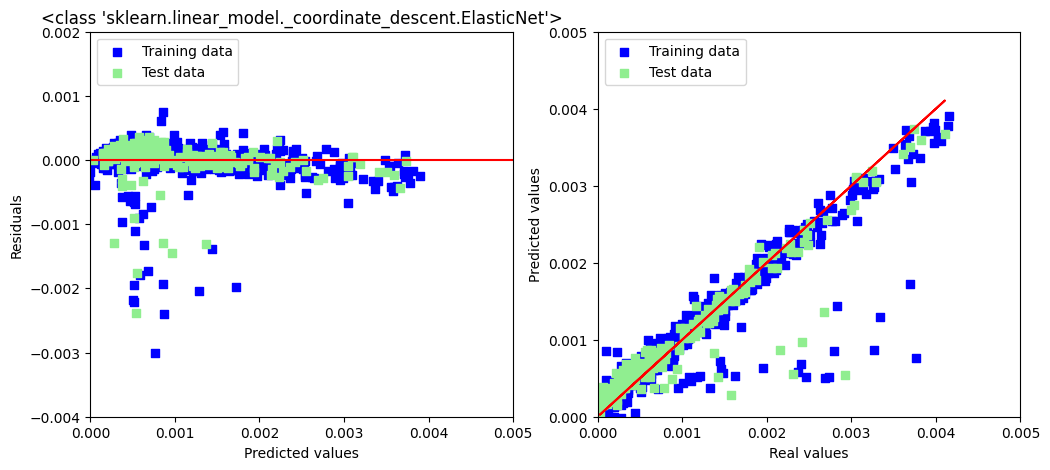

In [24]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
y_pred_t=plot_a(ElasticNet,estEN)

ax2= plt.subplot(122)
plot_b(y_pred_t)

<class 'sklearn.linear_model._coordinate_descent.ElasticNet'> picked 17 features and eliminated the other 0 features


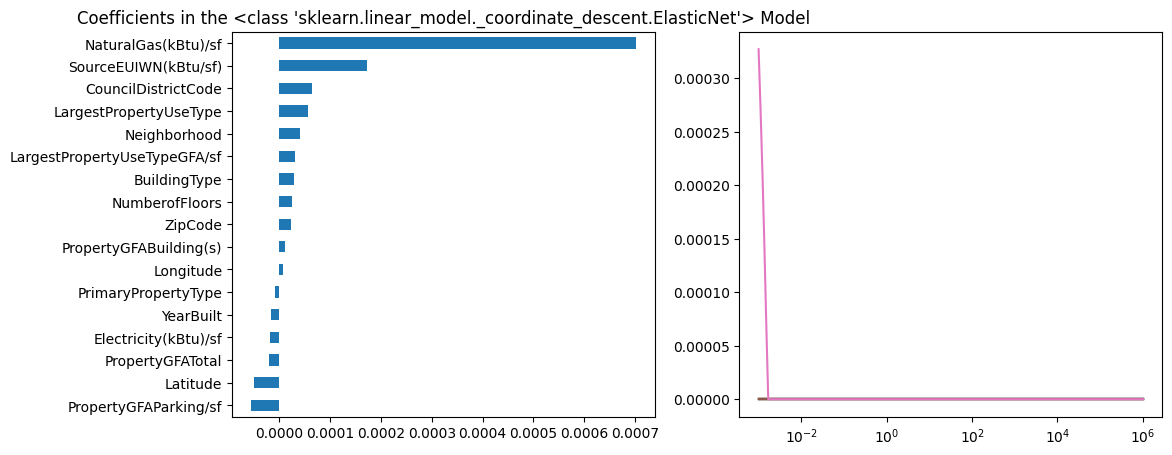

In [25]:
plt.figure(figsize=(12,5))
ax1=plt.subplot(121)
coef(estEN,ElasticNet)
ax2=plt.subplot(122)
evo(ElasticNet)
plt.show()

## <a name="C15">4-2-5 Régression KNN</a>

In [26]:
time_1=time.time()
(estKN, y_pred,KN,mae_KN)=regression(KNeighborsRegressor,{"n_neighbors": range(1,100)})
time_KN=time.time()-time_1

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................

[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=25; total time=   0.0s
[CV] END .....................................n_neighbors=25; total time=   0.0s
[CV] END .....................................n_neighbors=25; total time=   0.0s
[CV] END .....................................n_neighbors=25; total time=   0.0s
[CV] END .....................................n_neighbors=25; total time=   0.0s
[CV] END .....................................n_neighbors=26; total time=   0.0s
[CV] END .....................................n_neighbors=26; total time=   0.0s
[CV] END ...................

[CV] END .....................................n_neighbors=45; total time=   0.0s
[CV] END .....................................n_neighbors=45; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END ...................

[CV] END .....................................n_neighbors=68; total time=   0.0s
[CV] END .....................................n_neighbors=68; total time=   0.0s
[CV] END .....................................n_neighbors=68; total time=   0.0s
[CV] END .....................................n_neighbors=69; total time=   0.0s
[CV] END .....................................n_neighbors=69; total time=   0.0s
[CV] END .....................................n_neighbors=69; total time=   0.0s
[CV] END .....................................n_neighbors=69; total time=   0.0s
[CV] END .....................................n_neighbors=69; total time=   0.0s
[CV] END .....................................n_neighbors=70; total time=   0.0s
[CV] END .....................................n_neighbors=70; total time=   0.0s
[CV] END .....................................n_neighbors=70; total time=   0.0s
[CV] END .....................................n_neighbors=70; total time=   0.0s
[CV] END ...................

[CV] END .....................................n_neighbors=90; total time=   0.0s
[CV] END .....................................n_neighbors=91; total time=   0.0s
[CV] END .....................................n_neighbors=91; total time=   0.0s
[CV] END .....................................n_neighbors=91; total time=   0.0s
[CV] END .....................................n_neighbors=91; total time=   0.0s
[CV] END .....................................n_neighbors=91; total time=   0.0s
[CV] END .....................................n_neighbors=92; total time=   0.0s
[CV] END .....................................n_neighbors=92; total time=   0.0s
[CV] END .....................................n_neighbors=92; total time=   0.0s
[CV] END .....................................n_neighbors=92; total time=   0.0s
[CV] END .....................................n_neighbors=92; total time=   0.0s
[CV] END .....................................n_neighbors=93; total time=   0.0s
[CV] END ...................

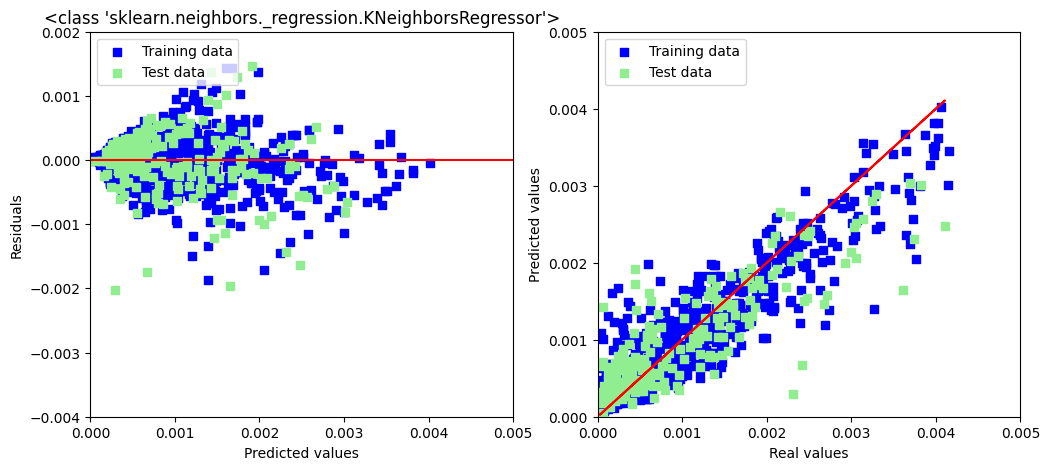

In [27]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
y_pred_t=plot_a(KNeighborsRegressor,estKN)

ax2= plt.subplot(122)
plot_b(y_pred_t)

## <a name="C16">4-2-6 Régression Kernel SVR</a>

In [28]:
time_1=time.time()
(estSV, y_pred,SV,mae_SV)=regression(SVR,{'kernel':['linear', 'poly', 'rbf'],'C' : np.logspace(-4, 0, 5),
             'epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
             'max_iter': [10, 100, 1000]})
time_SV=time.time()-time_1

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] END ....C=0.0001, epsilon=0, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ....C=0.0001, epsilon=0, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ....C=0.0001, epsilon=0, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ....C=0.0001, epsilon=0, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ....C=0.0001, epsilon=0, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ...C=0.0001, epsilon=0, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ...C=0.0001, epsilon=0, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ...C=0.0001, epsilon=0, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ...C=0.0001, epsilon=0, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ...C=0.0001, epsilon=0, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ..C=0.0001, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END ..C=0.0001, epsilon=0, kernel=linear

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\sv

[CV] END ....C=0.0001, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ....C=0.0001, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ....C=0.0001, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ....C=0.0001, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END .......C=0.0001, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .......C=0.0001, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .......C=0.0001, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .......C=0.0001, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .......C=0.0001, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ......C=0.0001, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ......C=0.0001, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ......C=0.0001, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ......C=0.0001, eps

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\sv

[CV] END .....C=0.0001, epsilon=0, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .....C=0.0001, epsilon=0, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .....C=0.0001, epsilon=0, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .C=0.0001, epsilon=0.01, kernel=linear, max_iter=10; total time=   0.0s
[CV] END .C=0.0001, epsilon=0.01, kernel=linear, max_iter=10; total time=   0.0s
[CV] END .C=0.0001, epsilon=0.01, kernel=linear, max_iter=10; total time=   0.0s
[CV] END .C=0.0001, epsilon=0.01, kernel=linear, max_iter=10; total time=   0.0s
[CV] END .C=0.0001, epsilon=0.01, kernel=linear, max_iter=10; total time=   0.0s
[CV] END C=0.0001, epsilon=0.01, kernel=linear, max_iter=100; total time=   0.0s
[CV] END C=0.0001, epsilon=0.01, kernel=linear, max_iter=100; total time=   0.0s
[CV] END C=0.0001, epsilon=0.01, kernel=linear, max_iter=100; total time=   0.0s
[CV] END C=0.0001, epsilon=0.01, kernel=linear, max_iter=100; total time=   0.0s
[CV] END C=0.0001, epsilon=0

[CV] END ......C=0.0001, epsilon=1, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ......C=0.0001, epsilon=1, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ......C=0.0001, epsilon=1, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ......C=0.0001, epsilon=1, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .....C=0.0001, epsilon=1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .....C=0.0001, epsilon=1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .....C=0.0001, epsilon=1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .....C=0.0001, epsilon=1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .....C=0.0001, epsilon=1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END ....C=0.0001, epsilon=2, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ....C=0.0001, epsilon=2, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ....C=0.0001, epsilon=2, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ....C=0.0001, epsil

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\sv

[CV] END ...C=0.001, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END .......C=0.001, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .......C=0.001, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .......C=0.001, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .......C=0.001, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .......C=0.001, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END ......C=0.001, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ......C=0.001, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ......C=0.001, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ......C=0.001, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ......C=0.001, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END .....C=0.001, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END .....C=0.001, epsil

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\sv

[CV] END ........C=0.001, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ........C=0.001, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ........C=0.001, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ........C=0.001, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ........C=0.001, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .......C=0.001, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .......C=0.001, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .......C=0.001, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .......C=0.001, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .......C=0.001, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ......C=0.001, epsilon=0, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END ......C=0.001, epsilon=0, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END ......C=0.001, epsi

[CV] END ...C=0.001, epsilon=1, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END ...C=0.001, epsilon=1, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END .......C=0.001, epsilon=1, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .......C=0.001, epsilon=1, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .......C=0.001, epsilon=1, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .......C=0.001, epsilon=1, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .......C=0.001, epsilon=1, kernel=poly, max_iter=10; total time=   0.0s
[CV] END ......C=0.001, epsilon=1, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ......C=0.001, epsilon=1, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ......C=0.001, epsilon=1, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ......C=0.001, epsilon=1, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ......C=0.001, epsilon=1, kernel=poly, max_iter=100; total time=   0.0s
[CV] END .....C=0.001, epsil

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\sv

[CV] END ....C=0.01, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END ....C=0.01, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END ....C=0.01, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END ....C=0.01, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END ....C=0.01, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END ........C=0.01, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END ........C=0.01, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END ........C=0.01, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END ........C=0.01, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END ........C=0.01, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .......C=0.01, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END .......C=0.01, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END .......C=0.01, epsi

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklear

[CV] END ......C=0.01, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ......C=0.01, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ......C=0.01, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ......C=0.01, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END .........C=0.01, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .........C=0.01, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .........C=0.01, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .........C=0.01, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .........C=0.01, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ........C=0.01, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ........C=0.01, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ........C=0.01, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ........C=0.01, eps

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .......C=0.01, epsilon=0, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .......C=0.01, epsilon=0, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .......C=0.01, epsilon=0, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .......C=0.01, epsilon=0, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END ...C=0.01, epsilon=0.01, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ...C=0.01, epsilon=0.01, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ...C=0.01, epsilon=0.01, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ...C=0.01, epsilon=0.01, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ...C=0.01, epsilon=0.01, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ..C=0.01, epsilon=0.01, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ..C=0.01, epsilon=0.01, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ..C=0.01, epsilon=0.01, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ..C=0.01, epsilon=0

[CV] END .........C=0.01, epsilon=1, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .........C=0.01, epsilon=1, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ........C=0.01, epsilon=1, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ........C=0.01, epsilon=1, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ........C=0.01, epsilon=1, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ........C=0.01, epsilon=1, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ........C=0.01, epsilon=1, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .......C=0.01, epsilon=1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .......C=0.01, epsilon=1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .......C=0.01, epsilon=1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .......C=0.01, epsilon=1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .......C=0.01, epsilon=1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END ......C=0.01, epsil

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\sv

[CV] END .....C=0.1, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END .....C=0.1, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END .....C=0.1, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END .....C=0.1, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END .........C=0.1, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .........C=0.1, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .........C=0.1, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .........C=0.1, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .........C=0.1, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END ........C=0.1, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ........C=0.1, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ........C=0.1, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ........C=0.1, epsi

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\skle

[CV] END .......C=0.1, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END .......C=0.1, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END .......C=0.1, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ..........C=0.1, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=0.1, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=0.1, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=0.1, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=0.1, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .........C=0.1, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .........C=0.1, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .........C=0.1, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .........C=0.1, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .........C=0.1, eps

[CV] END ......C=0.1, epsilon=0.1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.1, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.5, kernel=linear, max_iter=10; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.5, kernel=linear, max_iter=10; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.5, kernel=linear, max_iter=10; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.5, kernel=linear, max_iter=10; total time=   0.0s
[CV] END .....C=0.1, epsilon=0.5, kernel=linear, max_iter=10; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.5, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.5, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.5, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.5, kernel=linear, max_iter=100; total time=   0.0s
[CV] END ....C=0.1, epsilon=

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\sv

[CV] END .....C=1.0, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END .....C=1.0, epsilon=0, kernel=linear, max_iter=1000; total time=   0.0s
[CV] END .........C=1.0, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .........C=1.0, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .........C=1.0, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .........C=1.0, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .........C=1.0, epsilon=0, kernel=poly, max_iter=10; total time=   0.0s
[CV] END ........C=1.0, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ........C=1.0, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ........C=1.0, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ........C=1.0, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ........C=1.0, epsilon=0, kernel=poly, max_iter=100; total time=   0.0s
[CV] END .......C=1.0, epsil

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn

[CV] END .......C=1.0, epsilon=0, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ..........C=1.0, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=1.0, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=1.0, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=1.0, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=1.0, epsilon=0, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END .........C=1.0, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .........C=1.0, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .........C=1.0, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .........C=1.0, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END .........C=1.0, epsilon=0, kernel=rbf, max_iter=100; total time=   0.0s
[CV] END ........C=1.0, epsilon=0, kernel=rbf, max_iter=1000; total time=   0.0s
[CV] END ........C=1.0, epsi

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\sklearn\sv

[CV] END ......C=1.0, epsilon=0.01, kernel=poly, max_iter=10; total time=   0.0s
[CV] END ......C=1.0, epsilon=0.01, kernel=poly, max_iter=10; total time=   0.0s
[CV] END ......C=1.0, epsilon=0.01, kernel=poly, max_iter=10; total time=   0.0s
[CV] END .....C=1.0, epsilon=0.01, kernel=poly, max_iter=100; total time=   0.0s
[CV] END .....C=1.0, epsilon=0.01, kernel=poly, max_iter=100; total time=   0.0s
[CV] END .....C=1.0, epsilon=0.01, kernel=poly, max_iter=100; total time=   0.0s
[CV] END .....C=1.0, epsilon=0.01, kernel=poly, max_iter=100; total time=   0.0s
[CV] END .....C=1.0, epsilon=0.01, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ....C=1.0, epsilon=0.01, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ....C=1.0, epsilon=0.01, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ....C=1.0, epsilon=0.01, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ....C=1.0, epsilon=0.01, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ....C=1.0, epsilon=

[CV] END ........C=1.0, epsilon=2, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ........C=1.0, epsilon=2, kernel=poly, max_iter=100; total time=   0.0s
[CV] END ........C=1.0, epsilon=2, kernel=poly, max_iter=100; total time=   0.0s
[CV] END .......C=1.0, epsilon=2, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END .......C=1.0, epsilon=2, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END .......C=1.0, epsilon=2, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END .......C=1.0, epsilon=2, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END .......C=1.0, epsilon=2, kernel=poly, max_iter=1000; total time=   0.0s
[CV] END ..........C=1.0, epsilon=2, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=1.0, epsilon=2, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=1.0, epsilon=2, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=1.0, epsilon=2, kernel=rbf, max_iter=10; total time=   0.0s
[CV] END ..........C=1.0, ep

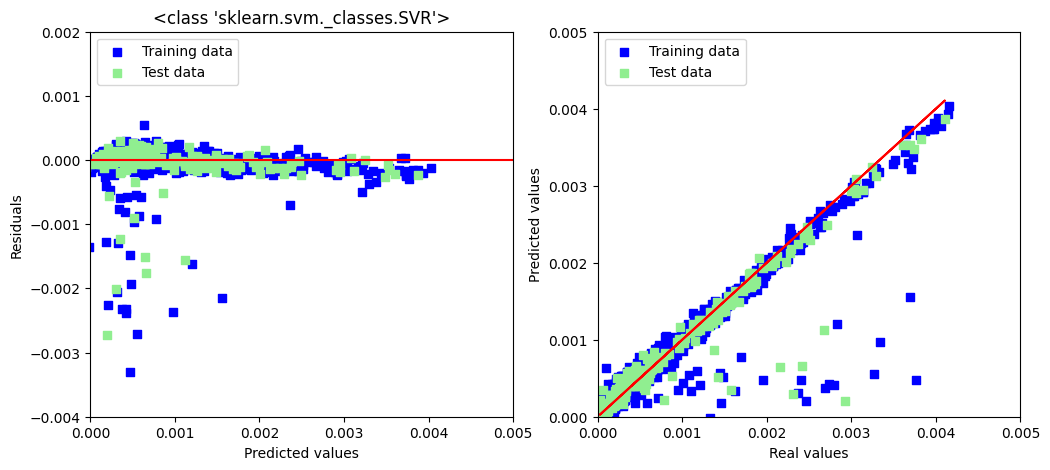

In [29]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
y_pred_t=plot_a(SVR,estSV)

ax2= plt.subplot(122)
plot_b(y_pred_t)

## <a name="C17">4-2-7 XGboost</a>

In [30]:
time_1=time.time()
(estXG, y_pred,XG,mae_XG)=regression(XGBRegressor,{'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]})
time_XG=time.time()-time_1

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[16:13:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=5, min_child_weight=4, n_estimators=500, nthread=4, objective=reg:linear, silent=1, subsample=0.7; total time=   0.3s
[16:13:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46b

[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=7, min_child_weight=4, n_estimators=500, nthread=4, objective=reg:linear, silent=1, subsample=0.7; total time=   0.3s
[16:13:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=7, min_child_weight=4, n_estimators=500, nthread=4, objective=reg:linear, silent=1, subsample=0.7; total time=   0.2s
[16:13:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of re

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_weight=4, n_estimators=500, nthread=4, objective=reg:linear, silent=1, subsample=0.7; total time=   0.2s
[16:13:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_weight=4, n_estimators=500, nthread=4, objective=reg:linear, silent=1, subsample=0.7; total time=   0.2s
[16:13:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of re

[CV] END colsample_bytree=0.7, learning_rate=0.07, max_depth=7, min_child_weight=4, n_estimators=500, nthread=4, objective=reg:linear, silent=1, subsample=0.7; total time=   0.2s
[16:13:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV] END colsample_bytree=0.7, learning_rate=0.07, max_depth=7, min_child_weight=4, n_estimators=500, nthread=4, objective=reg:linear, silent=1, subsample=0.7; total time=   0.2s
[16:13:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of re

In [31]:
XG.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.07,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

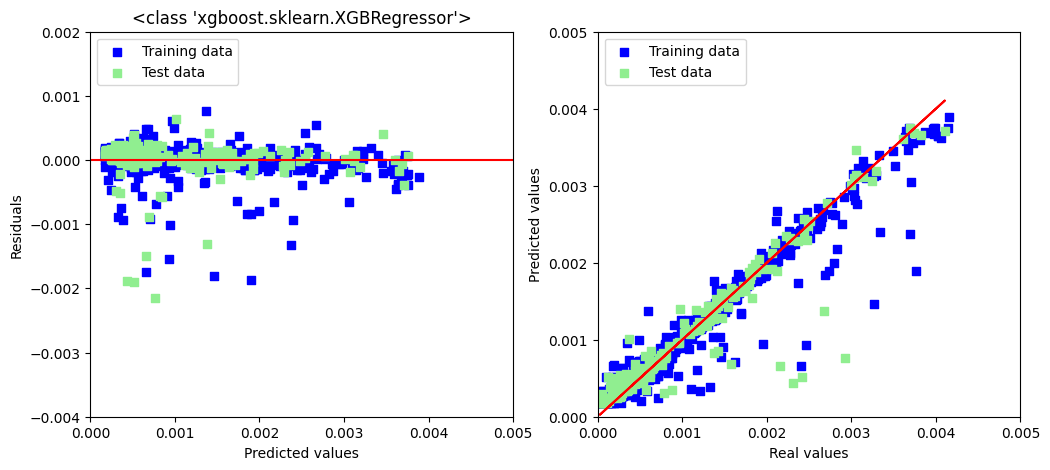

In [32]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
y_pred_t=plot_a(XGBRegressor,estXG)

ax2= plt.subplot(122)
plot_b(y_pred_t)

## <a name="C18">4-2-8 Random Forest</a>

In [33]:
time_1=time.time()
(estRF, y_pred,RF,mae_RF)=regression(RandomForestRegressor,{})
time_RF=time.time()-time_1

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.1s
Régression <class 'sklearn.ensemble._forest.RandomForestRegressor'> train set score R2: 0.99, MAE: 0.00, mean_squared_error: 0.00
Régression <class 'sklearn.ensemble._forest.RandomForestRegressor'> test set score R2: 0.89, MAE: 0.00, mean_squared_error: 0.00


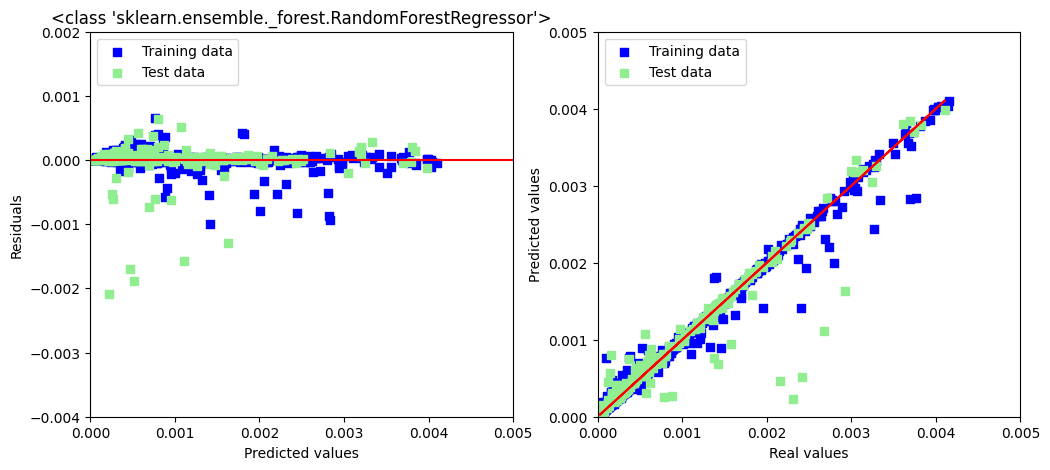

In [34]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
y_pred_t=plot_a(RandomForestRegressor,estRF)

ax2= plt.subplot(122)
plot_b(y_pred_t)

In [35]:
start_time = time.time()
importances = estRF.feature_importances_
std = np.std([tree.feature_importances_ for tree in estRF.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.031 seconds


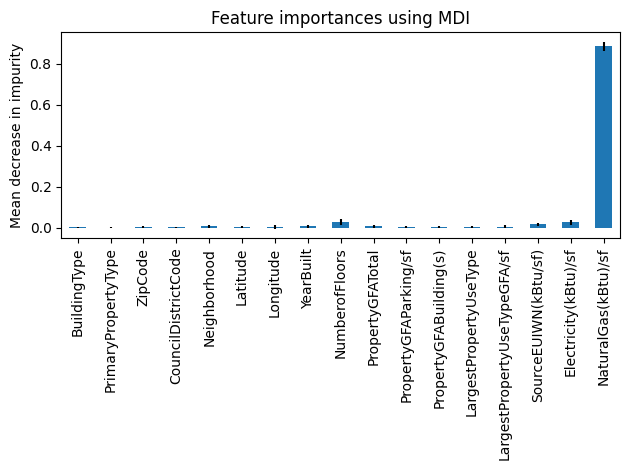

In [36]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## <a name="C19">4-2-9 Synthèse modèle prédictif 'TotalGHGEmissions/sf'</a>

In [37]:
#Tableau récapitulatif des résultats par modèle
ss=pd.DataFrame(columns=['modèle','meilleurs_paramètres', 'meilleur_score', 'process_time'])
dic={AN:[time_AN,mae_AN],
     KR:[time_KR,mae_KR],
     LA:[time_LA,mae_LA],
     EN:[time_EN,mae_EN],
     KN:[time_KN,mae_KN],
     SV:[time_SV,mae_SV],
     XG:[time_XG,mae_XG],
     RF:[time_RF,mae_RF]}
for model in [AN,KR,LA,EN,KN,SV,XG,RF]: 
    new_row = {'modèle':model.estimator, 
               'meilleurs_paramètres':model.best_params_, 
               'meilleur_score':model.best_score_, 
               'MAE':dic[model][1],
               'process_time':dic[model][0]}

    ss= ss.append(new_row, ignore_index=True)
ss

C:\Users\John\AppData\Local\Temp\ipykernel_15524\3128175340.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss= ss.append(new_row, ignore_index=True)
C:\Users\John\AppData\Local\Temp\ipykernel_15524\3128175340.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss= ss.append(new_row, ignore_index=True)
C:\Users\John\AppData\Local\Temp\ipykernel_15524\3128175340.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss= ss.append(new_row, ignore_index=True)
C:\Users\John\AppData\Local\Temp\ipykernel_15524\3128175340.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss= ss.append(new_row, ignore_index=True)
C:\Users\John\AppData\Lo

,modèle,meilleurs_paramètres,meilleur_score,process_time,MAE
0,DummyRegressor(),{'strategy': 'mean'},-0.010233,0.021939,0.000725
1,KernelRidge(),"{'alpha': 0.24945081352303167, 'gamma': 0.01, ...",0.896323,319.899521,0.000133
2,Lasso(),{'alpha': 0.001},-0.010233,2.558440,0.000725
3,ElasticNet(),"{'alpha': 0.07934096665797492, 'l1_ratio': 0.0}",0.871435,70.181626,0.000164
4,KNeighborsRegressor(),{'n_neighbors': 4},0.727397,7.606932,0.000341
5,SVR(),"{'C': 0.0001, 'epsilon': 0, 'kernel': 'linear'...",0.863830,5.133055,0.000138
6,"XGBRegressor(base_score=None, booster=None, ca...","{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.888572,15.335575,0.000142
7,RandomForestRegressor(),{},0.901196,9.350970,0.000109


## <a name="A7">**Partie 5 : Comparaison avec/sans la variable 'EnergyStar'**</a>

## On ajoute la colonne EnergyScore à la base de données

In [77]:
df33d=pd.read_csv('df33d.csv')

In [78]:
df34=df33d.copy()

[i for i in df34.columns if df34[i].dtype=='object']

#on targetencode les colonnes catégorielles
Target = 'TotalGHGEmissions/sf'
encoder = TargetEncoder()
for i in [i for i in df34.columns if df34[i].dtype=='object']:
    df34[i] = encoder.fit_transform(df34[i], df34[Target])

C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\John\Desktop\Formation\4-Anticipez les besoins en consommation de bâtiments\1-Projet\venv\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


## 'TotalGHGEmissions/sf': On applique le modèle avec EnergyStar

In [79]:
[i for i in df34.columns if i.endswith('sf')==True]

#transformons les data en X et y (SiteEnergyUse(kBtu))
df34.dropna(axis='rows', how='any',inplace=True)
X=df34.drop(columns=['SiteEnergyUseWN(kBtu)/sf',
            'TotalGHGEmissions/sf',
            'GHGEmissionsIntensity/sf'
                    ]
           )
y=df34['TotalGHGEmissions/sf'].values

X.shape

(702, 18)

In [80]:
#découpons en train et test sample
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y,
                                    test_size=0.2, # 30% des données dans le jeu de test
                                    random_state=42)

#standardisons X_train et X_test
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [81]:
#Entraînement du modèle avec les paramètres optimum sur tout le train set
estRF = RandomForestRegressor()
estRF.fit(X_train_std, y_train)

#Regression sur le test set
y_pred = estRF.predict(X_test_std)

#Compraison des scores train et test set
print('RandomForest train set Mean score R2: {:.2f}, MAE: {:.2f}, mean_squared_error: {:.2f}'
      .format(r2_score(y_train, estRF.predict(X_train_std)),mean_absolute_error(y_train, estRF.predict(X_train_std)),
              mean_squared_error(y_train, estRF.predict(X_train_std))))
print('RandomForest test set Mean score R2: {:.2f}, MAE: {:.2f}, mean_squared_error: {:.2f}'
      .format(r2_score(y_test, y_pred),mean_absolute_error(y_test, y_pred),
              mean_squared_error(y_test, y_pred)))

RandomForest train set Mean score R2: 0.98, MAE: 0.00, mean_squared_error: 0.00
RandomForest test set Mean score R2: 0.94, MAE: 0.00, mean_squared_error: 0.00


In [82]:
#Tableau récapitulatif des résultats avec EnergyStar
ssi=pd.DataFrame(columns=['modèle', 'meilleur_score','MAE'])
for model in [estRF]:    
    new_row = {'modèle':model, 
               'meilleur_score':r2_score(y_test, y_pred), 
               'MAE':mean_absolute_error(y_test, y_pred)
              }

    ssi= ssi.append(new_row, ignore_index=True)
ssi

C:\Users\John\AppData\Local\Temp\ipykernel_15524\3709026323.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ssi= ssi.append(new_row, ignore_index=True)


,modèle,meilleur_score,MAE
0,"(DecisionTreeRegressor(max_features=1.0, rando...",0.942745,0.000103


## 'TotalGHGEmissions/sf' : On applique le modèle sans EnergyStar

In [83]:
[i for i in df34.columns if i.endswith('sf')==True]

#transformons les data en X et y (SiteEnergyUse(kBtu))
df34.dropna(axis='rows', how='any',inplace=True)
X=df34.drop(columns=['SiteEnergyUseWN(kBtu)/sf',
            'ENERGYSTARScore',
            'TotalGHGEmissions/sf',
            'GHGEmissionsIntensity/sf'
                    ]
           )
y=df34['TotalGHGEmissions/sf'].values

X.shape

(702, 17)

In [84]:
#découpons en train et test sample
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y,
                                    test_size=0.2, # 30% des données dans le jeu de test
                                    random_state=42)

#standardisons X_train et X_test
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [85]:
#Entraînement du modèle avec les paramètres optimum sur tout le train set
estRF = RandomForestRegressor()
estRF.fit(X_train_std, y_train)

#Regression sur le test set
y_pred = estRF.predict(X_test_std)

#Compraison des scores train et test set
print('RandomForest train set Mean score R2: {:.2f}, MAE: {:.2f}, mean_squared_error: {:.2f}'
      .format(r2_score(y_train, estRF.predict(X_train_std)),mean_absolute_error(y_train, estRF.predict(X_train_std)),
              mean_squared_error(y_train, estRF.predict(X_train_std))))
print('RandomForest test set Mean score R2: {:.2f}, MAE: {:.2f}, mean_squared_error: {:.2f}'
      .format(r2_score(y_test, y_pred),mean_absolute_error(y_test, y_pred),
              mean_squared_error(y_test, y_pred)))

RandomForest train set Mean score R2: 0.98, MAE: 0.00, mean_squared_error: 0.00
RandomForest test set Mean score R2: 0.95, MAE: 0.00, mean_squared_error: 0.00


In [88]:
#Tableau récapitulatif des résultats sans EnergyStar
ssf=pd.DataFrame(columns=['modèle', 'meilleur_score','MAE'])
for model in [estRF]:    
   
    new_row = {'modèle':model, 
               'meilleur_score':r2_score(y_test, y_pred), 
               'MAE':mean_absolute_error(y_test, y_pred)            
               }
    ssf= ssf.append(new_row, ignore_index=True)
ssf

C:\Users\John\AppData\Local\Temp\ipykernel_15524\113136246.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ssf= ssf.append(new_row, ignore_index=True)


,modèle,meilleur_score,MAE
0,"(DecisionTreeRegressor(max_features=1.0, rando...",0.94682,0.000096


In [90]:
## Bilan

print(f'Pour la target TotalGHGEmissions/sf la variable EnergyStar améliore le score du modèle de {round((ssi.iloc[0,2]-ssf.iloc[0,2])*100,3)} %')

Pour la target TotalGHGEmissions/sf la variable EnergyStar améliore le score du modèle de 0.001 %
